## Mod 4 Project - Real Estate Price Forecast

## Time series analysis

The goal of this project is to provide insights for my real-estate firm on investment strategies in various zipcodes across the United States. The focus of this project will be on the states of NJ and NY, where the firm is actively looking to expand its portfolio

Based on this analysis of historical data on real-estate prices, obtained from the Zillow Research Page, we will try to conclude by providing 5 best zipcodes for the firm's investment strategy in these two states.


In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from math import sqrt
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [3]:
# Loading the Dataset

In [4]:
df = pd.read_csv('zillow_data.csv')
df

RegionID  RegionName                 City State              Metro  \
0         84654       60657              Chicago    IL            Chicago   
1         90668       75070             McKinney    TX  Dallas-Fort Worth   
2         91982       77494                 Katy    TX            Houston   
3         84616       60614              Chicago    IL            Chicago   
4         93144       79936              El Paso    TX            El Paso   
...         ...         ...                  ...   ...                ...   
14718     58333        1338             Ashfield    MA    Greenfield Town   
14719     59107        3293            Woodstock    NH          Claremont   
14720     75672       40404                Berea    KY           Richmond   
14721     93733       81225  Mount Crested Butte    CO                NaN   
14722     95851       89155             Mesquite    NV          Las Vegas   

      CountyName  SizeRank   1996-04   1996-05   1996-06  ...  2017-07  \
0           Cook         1  334200.0  335400.0  336500.0  ...  1005500   
1         Collin         2  235700.0  236900.0  236700.0  ...   308000   
2         Harris         3  210400.0  212200.0  212200.0  ...   321000   
3           Cook         4  498100.0  500900.0  503100.0  ...  1289800   
4        El Paso         5   77300.0   77300.0   77300.0  ...   119100   
...          ...       ...       ...       ...       ...  ...      ...   
14718   Franklin     14719   94600.0   94300.0   94000.0  ...   216800   
14719    Grafton     14720   92700.0   92500.0   92400.0  ...   202100   
14720    Madison     14721   57100.0   57300.0   57500.0  ...   121800   
14721   Gunnison     14722  191100.0  192400.0  193700.0  ...   662800   
14722      Clark     14723  176400.0  176300.0  176100.0  ...   333800   

       2017-08  2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  \
0      1007500  1007800  1009600  1013300  1018700  1024400  1030700  1033800   
1       310000   312500   314100   315000   316600   318100   319600   321100   
2       320600   320200   320400   320800   321200   321200   323000   326900   
3      1287700  1287400  1291500  1296600  1299000  1302700  1306400  1308500   
4       119400   120000   120300   120300   120300   120300   120500   121000   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14718   217700   218600   218500   218100   216400   213100   209800   209200   
14719   208400   212200   215200   214300   213100   213700   218300   222700   
14720   122800   124600   126700   128800   130600   131700   132500   133000   
14721   671200   682400   695600   695500   694700   706400   705300   681500   
14722   336400   339700   343800   346800   348900   350400   353000   356000   

       2018-04  
0      1030600  
1       321800  
2       329900  
3      1307000  
4       121500  
...        ...  
14718   209300  
14719   225800  
14720   133400  
14721   664400  
14722   357200  

[14723 rows x 272 columns]

Lets check for Unique values in our dataset

In [5]:
df.iloc[:, 0:6].nunique()

RegionID      14723
RegionName    14723
City           7554
State            51
Metro           701
CountyName     1212
dtype: int64

## Preparing the Dataset

Our dataframe is formatted as columns. We have both RegionID and RegionName, and a quick research online shows that the column RegionName is the one that refers to zipcodes.

In [6]:
df.rename({'RegionName': 'Zipcode'}, axis='columns', inplace=True)
df

RegionID  Zipcode                 City State              Metro  \
0         84654    60657              Chicago    IL            Chicago   
1         90668    75070             McKinney    TX  Dallas-Fort Worth   
2         91982    77494                 Katy    TX            Houston   
3         84616    60614              Chicago    IL            Chicago   
4         93144    79936              El Paso    TX            El Paso   
...         ...      ...                  ...   ...                ...   
14718     58333     1338             Ashfield    MA    Greenfield Town   
14719     59107     3293            Woodstock    NH          Claremont   
14720     75672    40404                Berea    KY           Richmond   
14721     93733    81225  Mount Crested Butte    CO                NaN   
14722     95851    89155             Mesquite    NV          Las Vegas   

      CountyName  SizeRank   1996-04   1996-05   1996-06  ...  2017-07  \
0           Cook         1  334200.0  335400.0  336500.0  ...  1005500   
1         Collin         2  235700.0  236900.0  236700.0  ...   308000   
2         Harris         3  210400.0  212200.0  212200.0  ...   321000   
3           Cook         4  498100.0  500900.0  503100.0  ...  1289800   
4        El Paso         5   77300.0   77300.0   77300.0  ...   119100   
...          ...       ...       ...       ...       ...  ...      ...   
14718   Franklin     14719   94600.0   94300.0   94000.0  ...   216800   
14719    Grafton     14720   92700.0   92500.0   92400.0  ...   202100   
14720    Madison     14721   57100.0   57300.0   57500.0  ...   121800   
14721   Gunnison     14722  191100.0  192400.0  193700.0  ...   662800   
14722      Clark     14723  176400.0  176300.0  176100.0  ...   333800   

       2017-08  2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  \
0      1007500  1007800  1009600  1013300  1018700  1024400  1030700  1033800   
1       310000   312500   314100   315000   316600   318100   319600   321100   
2       320600   320200   320400   320800   321200   321200   323000   326900   
3      1287700  1287400  1291500  1296600  1299000  1302700  1306400  1308500   
4       119400   120000   120300   120300   120300   120300   120500   121000   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14718   217700   218600   218500   218100   216400   213100   209800   209200   
14719   208400   212200   215200   214300   213100   213700   218300   222700   
14720   122800   124600   126700   128800   130600   131700   132500   133000   
14721   671200   682400   695600   695500   694700   706400   705300   681500   
14722   336400   339700   343800   346800   348900   350400   353000   356000   

       2018-04  
0      1030600  
1       321800  
2       329900  
3      1307000  
4       121500  
...        ...  
14718   209300  
14719   225800  
14720   133400  
14721   664400  
14722   357200  

[14723 rows x 272 columns]

Now, lets extract our dataset for NY and NJ states. 

In [7]:
nj_data = df.loc[df['State'] == 'NJ']
ny_data = df.loc[df['State'] == 'NY']

In [8]:
#Lets Review NJ dataset
nj_data

RegionID  Zipcode            City State          Metro  CountyName  \
57        60545     7030         Hoboken    NJ       New York      Hudson   
73        61148     8701        Lakewood    NJ       New York       Ocean   
158       61169     8753      Toms River    NJ       New York       Ocean   
187       60518     7002         Bayonne    NJ       New York      Hudson   
191       60639     7302     Jersey City    NJ       New York      Hudson   
...         ...      ...             ...   ...            ...         ...   
14469     61046     8319    Estell Manor    NJ  Atlantic City    Atlantic   
14511     60903     8006  Barnegat Light    NJ       New York       Ocean   
14537     61054     8328        Franklin    NJ   Philadelphia  Gloucester   
14632     61044     8317        Weymouth    NJ  Atlantic City    Atlantic   
14647     61023     8241   Port Republic    NJ  Atlantic City    Atlantic   

       SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
57           58  301600.0  302700.0  303800.0  ...  1789100  1803000  1818100   
73           74  153800.0  153400.0  153000.0  ...   400500   403900   408400   
158         159  123400.0  123200.0  122900.0  ...   258600   258700   259000   
187         188  145000.0  144500.0  143900.0  ...   318500   324100   330900   
191         192  137200.0  137800.0  138500.0  ...  1340200  1372300  1411000   
...         ...       ...       ...       ...  ...      ...      ...      ...   
14469     14470  117900.0  117000.0  116000.0  ...   186400   188600   188900   
14511     14512  254900.0  254400.0  254000.0  ...   807200   805700   807100   
14537     14538   86700.0   86800.0   87000.0  ...   151700   150500   150000   
14632     14633   98100.0   97500.0   96900.0  ...   166000   167500   169600   
14647     14648  117700.0  118000.0  118400.0  ...   183800   184700   186000   

       2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
57     1836900  1850100  1853500  1852200  1854400  1857600  1854300  
73      411000   412600   414000   415700   415600   413400   410700  
158     259500   261200   262500   262600   262400   263400   264300  
187     339000   347400   352800   355900   361500   368700   372900  
191    1435900  1446300  1447800  1454900  1453900  1439500  1427300  
...        ...      ...      ...      ...      ...      ...      ...  
14469   187900   187700   188100   189000   189600   189300   188800  
14511   813200   820800   825800   826800   820100   806700   795200  
14537   151900   155600   158500   159900   161100   161700   161300  
14632   171200   172100   171200   169900   169200   167500   165000  
14647   184100   175900   169100   165900   167800   173500   179300  

[502 rows x 272 columns]

In [9]:
# Now lets look at NY
ny_data

RegionID  Zipcode       City State     Metro  CountyName  SizeRank  \
6         61807    10467   New York    NY  New York       Bronx         7   
10        62037    11226   New York    NY  New York       Kings        11   
12        62087    11375   New York    NY  New York      Queens        13   
13        62045    11235   New York    NY  New York       Kings        14   
20        61625    10011   New York    NY  New York    New York        21   
...         ...      ...        ...   ...       ...         ...       ...   
14663     62430    12153  Sand Lake    NY    Albany  Rensselaer     14664   
14693     62433    12156   Schodack    NY    Albany  Rensselaer     14694   
14702     62599    12480  Shandaken    NY  Kingston      Ulster     14703   
14715     62556    12429     Esopus    NY  Kingston      Ulster     14716   
14717     62697    12720     Bethel    NY       NaN    Sullivan     14718   

        1996-04   1996-05   1996-06  ...   2017-07   2017-08   2017-09  \
6      152900.0  152700.0  152600.0  ...    394400    400000    407300   
10     162000.0  162300.0  162600.0  ...    860200    851000    853900   
12     252400.0  251800.0  251400.0  ...   1022600   1033700   1048600   
13     190500.0  191000.0  191500.0  ...    767300    777300    788800   
20          NaN       NaN       NaN  ...  12137600  12112600  12036600   
...         ...       ...       ...  ...       ...       ...       ...   
14663   95700.0   95000.0   94300.0  ...    191000    191700    192000   
14693   94400.0   94600.0   94800.0  ...    188600    189800    189600   
14702   70900.0   70400.0   70000.0  ...    160100    160600    160500   
14715   78300.0   78300.0   78200.0  ...    164200    166600    170000   
14717   62500.0   62600.0   62700.0  ...    122200    122700    122300   

        2017-10   2017-11   2017-12   2018-01   2018-02   2018-03   2018-04  
6        411600    413200    414300    413900    411400    413200    417900  
10       870000    885100    887800    890500    901700    930700    963200  
12      1066400   1081200   1088800   1092700   1089500   1084000   1084600  
13       793900    796000    799700    806600    810600    813400    816200  
20     12050100  12016300  11946500  11978100  11849300  11563000  11478300  
...         ...       ...       ...       ...       ...       ...       ...  
14663    193100    195400    198300    200500    202600    205200    207300  
14693    190500    191100    192000    193600    196100    198000    199400  
14702    160100    159900    159000    157000    157700    161000    163700  
14715    171000    170700    171300    172400    173600    175800    177500  
14717    122000    122200    122800    123200    123200    120700    117700  

[1015 rows x 272 columns]

Looking at the two datasets, we see that their are approximately 1500 zipcodes in the two states. Lets narrow it down based on the size of these zipcodes. We will only consider investment opportunities in only the top 20% biggest zipcodes by size. 

In [10]:
#NY
nj_rank_20 = nj_data.SizeRank.quantile(q=0.10)
nj_data_20= nj_data[nj_data['SizeRank']<nj_rank_20]

#NY
ny_rank_20 = ny_data.SizeRank.quantile(q = 0.1)
ny_data_20 = ny_data[ny_data['SizeRank']<ny_rank_20]

In [11]:
ny_data_20

RegionID  Zipcode         City State        Metro CountyName  SizeRank  \
6        61807    10467     New York    NY     New York      Bronx         7   
10       62037    11226     New York    NY     New York      Kings        11   
12       62087    11375     New York    NY     New York     Queens        13   
13       62045    11235     New York    NY     New York      Kings        14   
20       61625    10011     New York    NY     New York   New York        21   
...        ...      ...          ...   ...          ...        ...       ...   
2033     61938    10950       Monroe    NY     New York     Orange      2034   
2043     62005    11102     New York    NY     New York     Queens      2044   
2071     62334    12020       Milton    NY       Albany   Saratoga      2072   
2072     62823    12901  Plattsburgh    NY  Plattsburgh    Clinton      2073   
2088     61780    10304     New York    NY     New York   Richmond      2089   

       1996-04   1996-05   1996-06  ...   2017-07   2017-08   2017-09  \
6     152900.0  152700.0  152600.0  ...    394400    400000    407300   
10    162000.0  162300.0  162600.0  ...    860200    851000    853900   
12    252400.0  251800.0  251400.0  ...   1022600   1033700   1048600   
13    190500.0  191000.0  191500.0  ...    767300    777300    788800   
20         NaN       NaN       NaN  ...  12137600  12112600  12036600   
...        ...       ...       ...  ...       ...       ...       ...   
2033  140600.0  140600.0  140600.0  ...    264300    266800    269100   
2043  168600.0  169500.0  170400.0  ...   1013200   1015800   1010800   
2071  107100.0  106800.0  106500.0  ...    244200    245900    247500   
2072   78500.0   78000.0   77500.0  ...    137000    137100    137200   
2088  157500.0  157000.0  156500.0  ...    481900    490300    495600   

       2017-10   2017-11   2017-12   2018-01   2018-02   2018-03   2018-04  
6       411600    413200    414300    413900    411400    413200    417900  
10      870000    885100    887800    890500    901700    930700    963200  
12     1066400   1081200   1088800   1092700   1089500   1084000   1084600  
13      793900    796000    799700    806600    810600    813400    816200  
20    12050100  12016300  11946500  11978100  11849300  11563000  11478300  
...        ...       ...       ...       ...       ...       ...       ...  
2033    270800    273000    275400    277600    279200    280900    282400  
2043   1008000   1027500   1053700   1071500   1072700   1088200   1112100  
2071    249100    250600    252000    253300    254400    254900    255100  
2072    137700    138500    139400    140000    139900    139600    139600  
2088    498800    502000    505600    509900    515700    523500    529800  

[102 rows x 272 columns]

In [12]:
nj_data_20

RegionID  Zipcode             City State          Metro  CountyName  \
57       60545     7030          Hoboken    NJ       New York      Hudson   
73       61148     8701         Lakewood    NJ       New York       Ocean   
158      61169     8753       Toms River    NJ       New York       Ocean   
187      60518     7002          Bayonne    NJ       New York      Hudson   
191      60639     7302      Jersey City    NJ       New York      Hudson   
214      60599     7093    West New York    NJ       New York      Hudson   
278      61200     8831           Monroe    NJ       New York   Middlesex   
319      60594     7087       Union City    NJ       New York      Hudson   
519      60642     7305      Jersey City    NJ       New York      Hudson   
528      61175     8759       Manchester    NJ       New York       Ocean   
546      60560     7047     North Bergen    NJ       New York      Hudson   
549      61229     8873         Franklin    NJ       New York    Somerset   
568      61093     8527          Jackson    NJ       New York       Ocean   
576      60776     7728         Freehold    NJ       New York    Monmouth   
622      60565     7055          Passaic    NJ       New York     Passaic   
641      60519     7003       Bloomfield    NJ       New York       Essex   
660      60643     7306      Jersey City    NJ       New York      Hudson   
678      60916     8021       Lindenwold    NJ   Philadelphia      Camden   
832      60714     7601       Hackensack    NJ       New York      Bergen   
840      60688     7470            Wayne    NJ       New York     Passaic   
850      60945     8054        Mt Laurel    NJ   Philadelphia  Burlington   
861      60592     7083            Union    NJ       New York       Union   
916      60944     8053          Evesham    NJ   Philadelphia  Burlington   
947      60540     7024         Fort Lee    NJ       New York      Bergen   
988      61100     8540        Princeton    NJ        Trenton      Mercer   
1043     61214     8854       Piscataway    NJ       New York   Middlesex   
1068     61173     8757         Berkeley    NJ       New York       Ocean   
1098     60971     8081          Winslow    NJ   Philadelphia      Camden   
1109     60763     7712            Ocean    NJ       New York    Monmouth   
1114     60608     7104           Newark    NJ       New York       Essex   
1168     61153     8724            Brick    NJ       New York       Ocean   
1170     60563     7052      West Orange    NJ       New York       Essex   
1179     61186     8816   East Brunswick    NJ       New York   Middlesex   
1280     60884     7960           Morris    NJ       New York      Morris   
1411     61187     8817           Edison    NJ       New York   Middlesex   
1480     61021     8234       Egg Harbor    NJ  Atlantic City    Atlantic   
1498     60774     7726        Manalapan    NJ       New York    Monmouth   
1581     60551     7036           Linden    NJ       New York       Union   
1674     61219     8861      Perth Amboy    NJ       New York   Middlesex   
1703     60793     7753          Neptune    NJ       New York    Monmouth   
1737     60644     7307      Jersey City    NJ       New York      Hudson   
1744     60983     8094           Monroe    NJ   Philadelphia  Gloucester   
1766     61246     8902  North Brunswick    NJ       New York   Middlesex   
1774     60909     8012       Gloucester    NJ   Philadelphia      Camden   
1778     61071     8360         Vineland    NJ       Vineland  Cumberland   
1796     60609     7105           Newark    NJ       New York       Essex   
1842     61216     8857       Old Bridge    NJ       New York   Middlesex   
1941     61208     8844     Hillsborough    NJ       New York    Somerset   
2051     61245     8901    New Brunswick    NJ       New York   Middlesex   
2059     60985     8096         Deptford    NJ   Philadelphia  Gloucester   
2115     61036     8302        Bridgeton    NJ       Vineland  Cumberland   

 

The next step is to format the data from the Wide format to a long format. 

In [13]:
# Create a function to melt data and make it into time Series. (Used a starter code here)



In [14]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','Zipcode', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [15]:
nj_df = melt_data(nj_data_20)
ny_df = melt_data(ny_data_20)

In [16]:
nj_df

value
time                     
1996-04-01  151427.450980
1996-05-01  151270.588235
1996-06-01  151074.509804
1996-07-01  150845.098039
1996-08-01  150641.176471
...                   ...
2017-12-01  382262.745098
2018-01-01  384276.470588
2018-02-01  386890.196078
2018-03-01  389796.078431
2018-04-01  391421.568627

[265 rows x 1 columns]

In [17]:
ny_df

value
time                    
1996-04-01  1.875185e+05
1996-05-01  1.877478e+05
1996-06-01  1.879826e+05
1996-07-01  1.882207e+05
1996-08-01  1.885152e+05
...                  ...
2017-12-01  1.090985e+06
2018-01-01  1.095649e+06
2018-02-01  1.098489e+06
2018-03-01  1.098153e+06
2018-04-01  1.098252e+06

[265 rows x 1 columns]

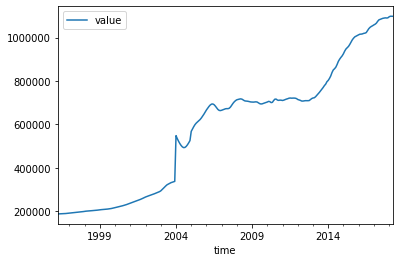

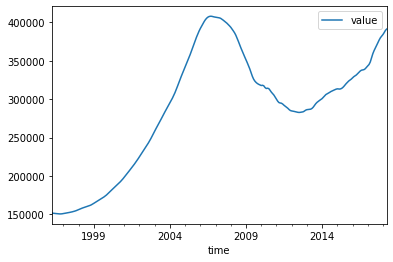

In [18]:
ny_df.plot()
nj_df.plot()

In [19]:
def plot_roll(ts, name=''):
    
    '''Takes a time series and plots it along with its rolling mean and its rolling standard deviation.
    Calculates and prints results from Dickey-Fuller test.'''
    
    # Calculate rolling mean and rolling standard deviation:
    rolmean = ts.rolling(window = 6, center = False).mean()
    rolstd = ts.rolling(window = 6, center = False).std()
    
    # Plot original time series and its rolling mean/standard deviation
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=ts.index, y=ts.value, name='Original',
                             line_color='blue'))
    fig.add_trace(go.Scatter(x=rolmean.index, y=rolmean.value, name='Rolling Mean',
                             line_color='red'))
    fig.add_trace(go.Scatter(x=rolstd.index, y=rolstd.value, name='Rolling Std',
                             line_color='green'))
    fig.update_layout(title_text=f'{name} Rolling Mean & Standard Deviation',
                      xaxis_rangeslider_visible=True)
    fig.show();
    
    #Perform Dickey-Fuller test:
    print (f'{name} Results of Dickey-Fuller Test:')
    dftest = adfuller(ts['value'])

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return print(dfoutput)

In [20]:
#Lets import some Statsmodels libraries

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.graph_objects as go

In [21]:
nj_roll = plot_roll(nj_df, 'New Jersey')

New Jersey Results of Dickey-Fuller Test:
Test Statistic                  -2.269687
p-value                          0.181931
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [22]:
ny_roll = plot_roll(ny_df, 'New York')

New York Results of Dickey-Fuller Test:
Test Statistic                   0.436941
p-value                          0.982825
#Lags Used                       0.000000
Number of Observations Used    264.000000
Critical Value (1%)             -3.455365
Critical Value (5%)             -2.872551
Critical Value (10%)            -2.572638
dtype: float64


In [23]:
# function to calculate gain percentage (ROI) on previous 2, 5 and 10 years
def calculate_gain(ts, plot=True):
    
    '''Takes a real estate time series and performs calculations on returns over investments
    for periods of 2, 5 and 10 years.'''
    
    # calculates ROI by taking current value, decreasing investment(value at x steps in past) and 
    # dividing by investment. Multiplies by 100 to get percentage number
    roi_2 = (ts - ts.shift(periods=24))/ts.shift(periods=24)*100
    roi_5 = (ts - ts.shift(periods=60))/ts.shift(periods=60)*100
    roi_10 = (ts - ts.shift(periods=120))/ts.shift(periods=120)*100
    roi_2.dropna(inplace=True)
    roi_5.dropna(inplace=True)
    roi_10.dropna(inplace=True)
    
    # plot results
    if plot:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=roi_2.index, y=roi_2.value, name='2-Year Investment',
                                 line_color='deepskyblue'))
        fig.add_trace(go.Scatter(x=roi_5.index, y=roi_5.value, name='5-Year Investment',
                                 line_color='red'))
        fig.add_trace(go.Scatter(x=roi_10.index, y=roi_10.value, name='10-Year Investment',
                                 line_color='gray'))
        fig.update_layout(title_text='Mean Zillow Home Value Index (ZHVI) - ROI Over Time Invested',
                          xaxis_rangeslider_visible=True)
        fig.show()
    
    # saves new ts with returns for 2, 5 and 10 periods
    return roi_2, roi_5, roi_10

In [24]:
nj_2, nj_5, nj_10 = calculate_gain(nj_df)

In [25]:
ny_2, ny_5, ny_10 = calculate_gain(ny_df)

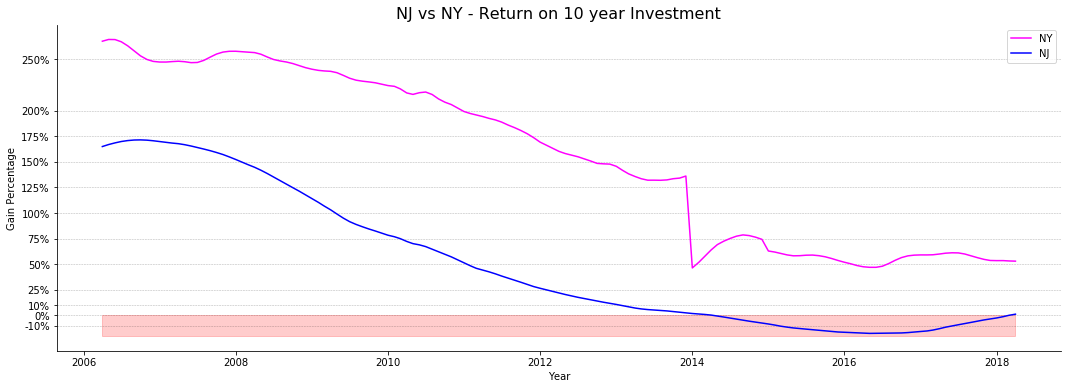

In [26]:
# create visualization of both time series:
plt.figure(figsize=(18,6))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.plot(ny_10, label='NY', color='magenta')
ax.plot(nj_10, label='NJ', color='blue')
ax.fill_between(ny_10.index, ny_10.value<0, -20, color='red', alpha=.2)
plt.title('NJ vs NY - Return on 10 year Investment', fontsize=16)
ax.set_ylabel('Gain Percentage')
ax.set_xlabel('Year')
plt.yticks([-10,0,10,25,50,75,100,125,150,175,200, 250], [str(x) + "%" for x in [-10,0,10,25,50,75,100,125,150,175,200, 250]], fontsize=10)
ax.grid(which='major', axis='y', linestyle= "--", lw=0.5, color="black", alpha=0.3)
ax.legend()
plt.show();

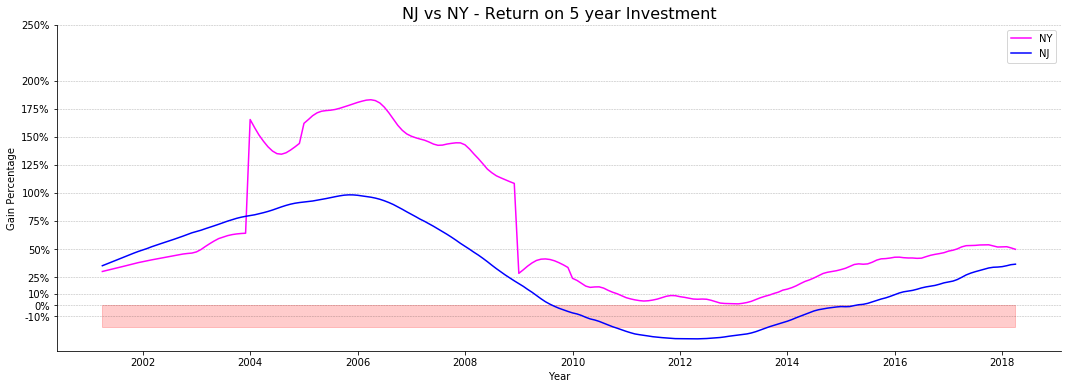

In [27]:
# create visualization of both time series:
plt.figure(figsize=(18,6))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.plot(ny_5, label='NY', color='magenta')
ax.plot(nj_5, label='NJ', color='blue')
ax.fill_between(ny_5.index, ny_5.value<0, -20, color='red', alpha=.2)
plt.title('NJ vs NY - Return on 5 year Investment', fontsize=16)
ax.set_ylabel('Gain Percentage')
ax.set_xlabel('Year')
plt.yticks([-10,0,10,25,50,75,100,125,150,175,200, 250], [str(x) + "%" for x in [-10,0,10,25,50,75,100,125,150,175,200, 250]], fontsize=10)
ax.grid(which='major', axis='y', linestyle= "--", lw=0.5, color="black", alpha=0.3)
ax.legend()
plt.show();

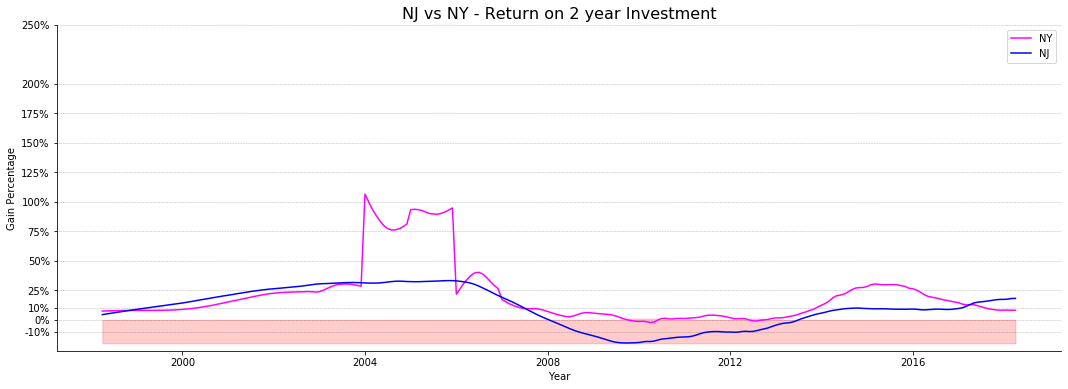

In [28]:
# create visualization of both time series:
plt.figure(figsize=(18,6))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.plot(ny_2, label='NY', color='magenta')
ax.plot(nj_2, label='NJ', color='blue')
ax.fill_between(ny_2.index, ny_2.value<0, -20, color='red', alpha=.2)
plt.title('NJ vs NY - Return on 2 year Investment', fontsize=16)
ax.set_ylabel('Gain Percentage')
ax.set_xlabel('Year')
plt.yticks([-10,0,10,25,50,75,100,125,150,175,200, 250], [str(x) + "%" for x in [-10,0,10,25,50,75,100,125,150,175,200, 250]], fontsize=10)
ax.grid(which='major', axis='y', linestyle= "--", lw=0.5, color="black", alpha=0.3)
ax.legend()
plt.show();

Looking closely at the 2-year investment chart, it seems clear that even though NY seems to have been a better investment opportunity till 2016, NJ has a more promising trend than NY. 

Considering our dataset, The 2-year ROI seems like a better metric to look at. This is because the 2008 financial crisis could skew historical data based projections. Going forward, we will narrow down our dataset to only include the data post 2008, to get around this one-off anomaly. 

Also, since our goal is to narrow down to 5 zipcodes that offer the best opportunity of investment, we will look at zipcodes in NJ going forward, as it clearly seems like the much better State to look at. We could compare invididual zipcodes in both states, but it is out of the current scope or requirements. 

Lets still However, do one final check of statinarity on the two NJ, and NY datasets, to get some idea of their parameters

In [29]:
# checking stationarity 
returns = [ny_5, nj_5, ny_2, nj_2]
names = ['NY 5-Year', 'NJ 5-Year', 'NY 5-Year', 'NJ 5-Year']
for ts, name in zip(returns, names):
    plot_roll(ts, name=name)

NY 5-Year Results of Dickey-Fuller Test:
Test Statistic                  -1.207903
p-value                          0.670187
#Lags Used                       0.000000
Number of Observations Used    204.000000
Critical Value (1%)             -3.462818
Critical Value (5%)             -2.875815
Critical Value (10%)            -2.574379
dtype: float64


NJ 5-Year Results of Dickey-Fuller Test:
Test Statistic                  -3.170973
p-value                          0.021728
#Lags Used                      13.000000
Number of Observations Used    191.000000
Critical Value (1%)             -3.465059
Critical Value (5%)             -2.876794
Critical Value (10%)            -2.574901
dtype: float64


NY 5-Year Results of Dickey-Fuller Test:
Test Statistic                  -2.234915
p-value                          0.193818
#Lags Used                       0.000000
Number of Observations Used    240.000000
Critical Value (1%)             -3.457894
Critical Value (5%)             -2.873659
Critical Value (10%)            -2.573229
dtype: float64


NJ 5-Year Results of Dickey-Fuller Test:
Test Statistic                  -2.317533
p-value                          0.166376
#Lags Used                      13.000000
Number of Observations Used    227.000000
Critical Value (1%)             -3.459490
Critical Value (5%)             -2.874358
Critical Value (10%)            -2.573602
dtype: float64


Our Data looks non-stationary for the most part with the Dickey Fuller Tests. Lets check the ACF and PACF charts. 

In [30]:
def acf_pacf(ts,alags=40,plags=40):
    '''Takes timeseries and plots ACF and PACF'''
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(14,8))
    plot_acf(ts,lags=alags, zero=True,ax=ax1)
    plot_pacf(ts,lags=plags, ax=ax2, method = 'ywmle')
    plt.show();


 
 NY 5-Year 



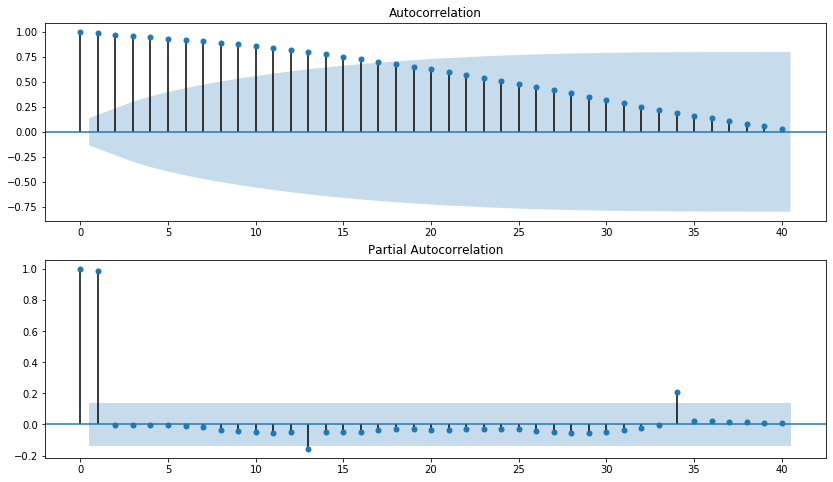


 
 NJ 5-Year 



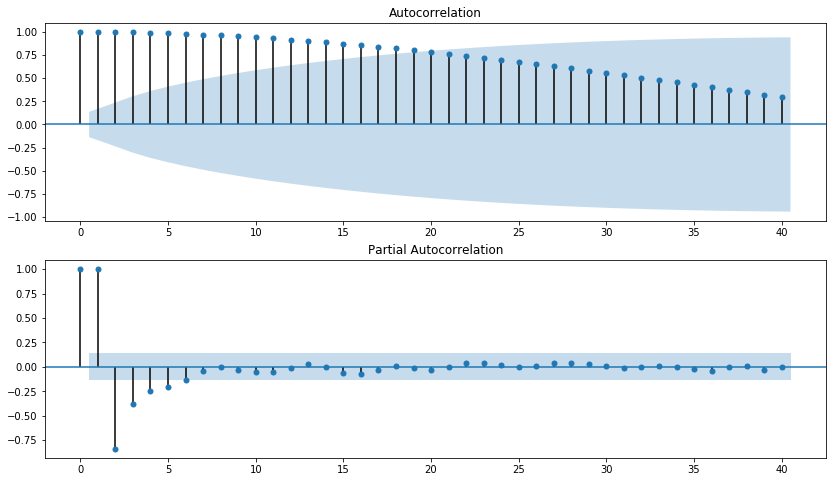


 
 NY 5-Year 



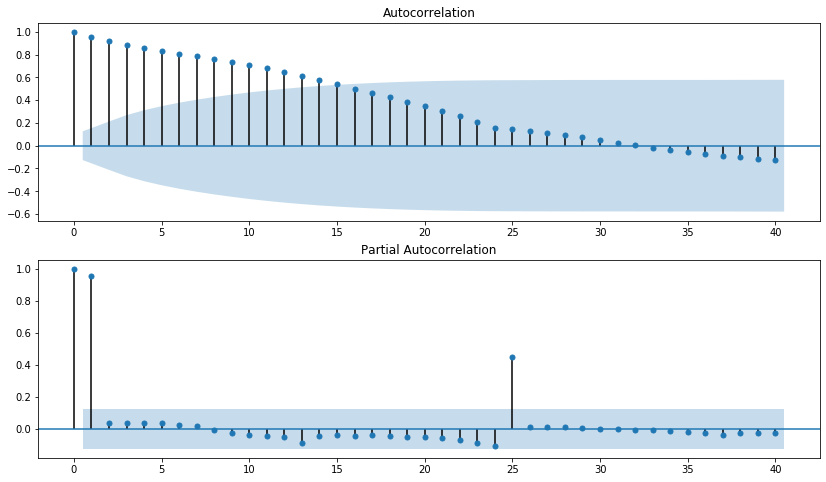


 
 NJ 5-Year 



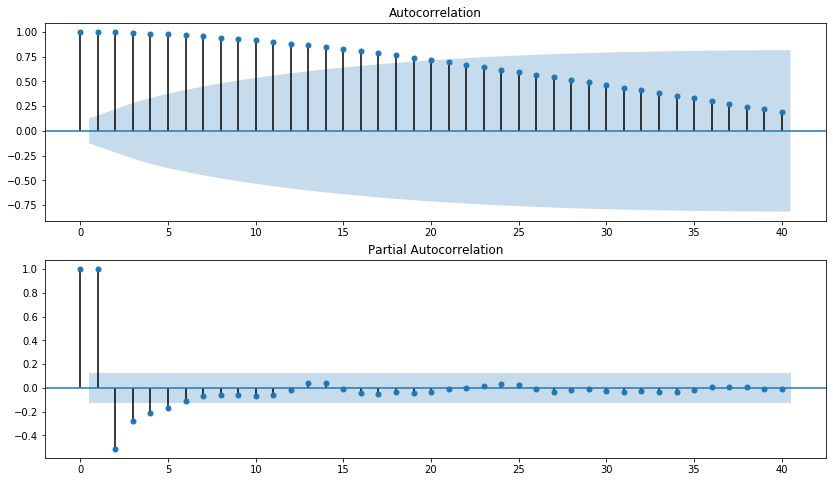

In [31]:
for ts, name in zip(returns, names):
    print(f'\n \n {name} \n')
    acf_pacf(ts)

Based on the PACF graphs, it looks like we are looking at an AR order of 1 or 2. Lets try the seasonal decomposition function to break our plots down to its components. We will use an additive model for this

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

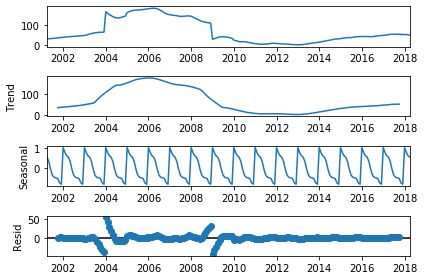

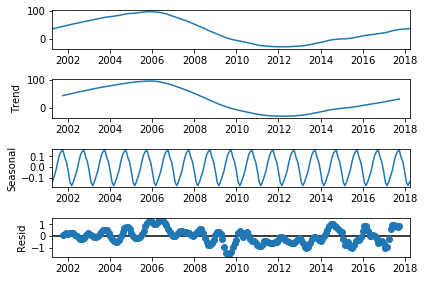

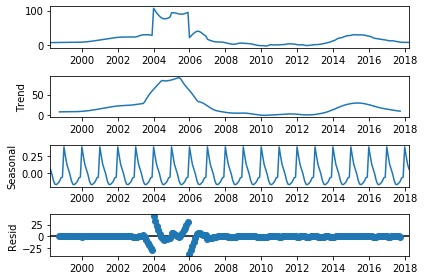

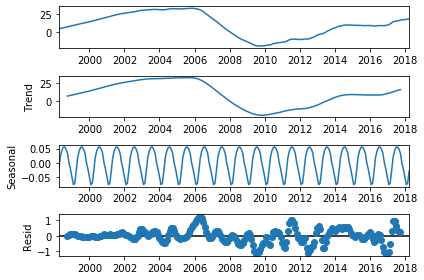

In [33]:
for df in returns:
    result = seasonal_decompose(df, model='additive')
    result.plot()

We see from our decomposition plots that even though slight seasonality exists, the magnitude of seasonality is extrmely small compared to the magnitude of the trend component.

In [34]:
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults

In [35]:
from pmdarima import auto_arima

In [36]:
for df in returns:
    print(auto_arima(df, seasonal=False).summary())

    

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  205
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -745.662
Date:                Wed, 26 May 2021   AIC                           1493.325
Time:                        22:12:56   BIC                           1496.643
Sample:                             0   HQIC                          1494.667
                                - 205                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        87.5869      1.272     68.866      0.000      85.094      90.080
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             70562.45
Prob(Q):                              0.97   Pr

Based on the grid search, we get a recommended model as SARIMAX (If considered State level data). This might be a good metric to compare with the zipcode specific data in our next steps. 

In [37]:
nj_data_20

RegionID  Zipcode             City State          Metro  CountyName  \
57       60545     7030          Hoboken    NJ       New York      Hudson   
73       61148     8701         Lakewood    NJ       New York       Ocean   
158      61169     8753       Toms River    NJ       New York       Ocean   
187      60518     7002          Bayonne    NJ       New York      Hudson   
191      60639     7302      Jersey City    NJ       New York      Hudson   
214      60599     7093    West New York    NJ       New York      Hudson   
278      61200     8831           Monroe    NJ       New York   Middlesex   
319      60594     7087       Union City    NJ       New York      Hudson   
519      60642     7305      Jersey City    NJ       New York      Hudson   
528      61175     8759       Manchester    NJ       New York       Ocean   
546      60560     7047     North Bergen    NJ       New York      Hudson   
549      61229     8873         Franklin    NJ       New York    Somerset   
568      61093     8527          Jackson    NJ       New York       Ocean   
576      60776     7728         Freehold    NJ       New York    Monmouth   
622      60565     7055          Passaic    NJ       New York     Passaic   
641      60519     7003       Bloomfield    NJ       New York       Essex   
660      60643     7306      Jersey City    NJ       New York      Hudson   
678      60916     8021       Lindenwold    NJ   Philadelphia      Camden   
832      60714     7601       Hackensack    NJ       New York      Bergen   
840      60688     7470            Wayne    NJ       New York     Passaic   
850      60945     8054        Mt Laurel    NJ   Philadelphia  Burlington   
861      60592     7083            Union    NJ       New York       Union   
916      60944     8053          Evesham    NJ   Philadelphia  Burlington   
947      60540     7024         Fort Lee    NJ       New York      Bergen   
988      61100     8540        Princeton    NJ        Trenton      Mercer   
1043     61214     8854       Piscataway    NJ       New York   Middlesex   
1068     61173     8757         Berkeley    NJ       New York       Ocean   
1098     60971     8081          Winslow    NJ   Philadelphia      Camden   
1109     60763     7712            Ocean    NJ       New York    Monmouth   
1114     60608     7104           Newark    NJ       New York       Essex   
1168     61153     8724            Brick    NJ       New York       Ocean   
1170     60563     7052      West Orange    NJ       New York       Essex   
1179     61186     8816   East Brunswick    NJ       New York   Middlesex   
1280     60884     7960           Morris    NJ       New York      Morris   
1411     61187     8817           Edison    NJ       New York   Middlesex   
1480     61021     8234       Egg Harbor    NJ  Atlantic City    Atlantic   
1498     60774     7726        Manalapan    NJ       New York    Monmouth   
1581     60551     7036           Linden    NJ       New York       Union   
1674     61219     8861      Perth Amboy    NJ       New York   Middlesex   
1703     60793     7753          Neptune    NJ       New York    Monmouth   
1737     60644     7307      Jersey City    NJ       New York      Hudson   
1744     60983     8094           Monroe    NJ   Philadelphia  Gloucester   
1766     61246     8902  North Brunswick    NJ       New York   Middlesex   
1774     60909     8012       Gloucester    NJ   Philadelphia      Camden   
1778     61071     8360         Vineland    NJ       Vineland  Cumberland   
1796     60609     7105           Newark    NJ       New York       Essex   
1842     61216     8857       Old Bridge    NJ       New York   Middlesex   
1941     61208     8844     Hillsborough    NJ       New York    Somerset   
2051     61245     8901    New Brunswick    NJ       New York   Middlesex   
2059     60985     8096         Deptford    NJ   Philadelphia  Gloucester   
2115     61036     8302        Bridgeton    NJ       Vineland  Cumberland   

 

In [38]:
#Calculate historical return on investment
nj_data_20['ROI']= (nj_data_20['2018-04']/nj_data_20['1996-04'])-1
#Calculate standard deviation of monthly values
nj_data_20['std']=nj_data_20.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)
#Calculate historical mean value
nj_data_20['mean']=nj_data_20.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)
#Calculate coefficient of variance
nj_data_20['CV']=nj_data_20['std']/nj_data_20['mean']
#Show calculated values
nj_data_20[['Zipcode','std','mean','ROI','CV']].head()

#Descriptive statistics of coefficients of variance.
print(nj_data_20.CV.describe())
#Define upper limit of CV according to risk profile.
upper_cv = nj_data_20.CV.quantile(.6)
print(f'\nCV upper limit: {upper_cv}')
#Get the 5 zipcodes with highest ROIs within the firms risk profile.
nj_top5 = nj_data_20[nj_data_20['CV']<upper_cv].sort_values('ROI',axis=0,ascending=False)[:5]
print('\n Best 5 Zipcodes:')
nj_top5[['Zipcode','ROI','CV']]

count    51.000000
mean      0.283421
std       0.063233
min       0.210765
25%       0.239122
50%       0.263380
75%       0.309097
max       0.531919
Name: CV, dtype: float64

CV upper limit: 0.2763133333565313

 Best 5 Zipcodes:


Zipcode       ROI        CV
947      7024  1.729823  0.267907
73       8701  1.670351  0.275104
988      8540  1.488527  0.256451
1170     7052  1.371446  0.263380
1842     8857  1.366160  0.265503

Now that we have our top 5 zipcodes in NJ, lets try and analyze them side by side. We will then model each individually and see the results

In [39]:
nj_top5

RegionID  Zipcode         City State     Metro CountyName  SizeRank  \
947      60540     7024     Fort Lee    NJ  New York     Bergen       948   
73       61148     8701     Lakewood    NJ  New York      Ocean        74   
988      61100     8540    Princeton    NJ   Trenton     Mercer       989   
1170     60563     7052  West Orange    NJ  New York      Essex      1171   
1842     61216     8857   Old Bridge    NJ  New York  Middlesex      1843   

       1996-04   1996-05   1996-06  ...  2017-11  2017-12  2018-01  2018-02  \
947   260200.0  260000.0  259900.0  ...   688500   693500   700500   704400   
73    153800.0  153400.0  153000.0  ...   412600   414000   415700   415600   
988   270200.0  269700.0  269100.0  ...   674900   672800   670100   669100   
1170  165300.0  164900.0  164400.0  ...   387300   386700   387900   390600   
1842  151300.0  151400.0  151500.0  ...   345200   346600   348400   351300   

      2018-03  2018-04       ROI            std           mean        CV  
947    708000   710300  1.729823  136679.525708  510175.849057  0.267907  
73     413400   410700  1.670351   78323.563147  284704.905660  0.275104  
988    670200   672400  1.488527  129106.969943  503436.981132  0.256451  
1170   392100   392000  1.371446   79965.935586  303614.339623  0.263380  
1842   355200   358000  1.366160   76083.897587  286565.283019  0.265503  

[5 rows x 276 columns]

In [40]:
nj_data

RegionID  Zipcode            City State          Metro  CountyName  \
57        60545     7030         Hoboken    NJ       New York      Hudson   
73        61148     8701        Lakewood    NJ       New York       Ocean   
158       61169     8753      Toms River    NJ       New York       Ocean   
187       60518     7002         Bayonne    NJ       New York      Hudson   
191       60639     7302     Jersey City    NJ       New York      Hudson   
...         ...      ...             ...   ...            ...         ...   
14469     61046     8319    Estell Manor    NJ  Atlantic City    Atlantic   
14511     60903     8006  Barnegat Light    NJ       New York       Ocean   
14537     61054     8328        Franklin    NJ   Philadelphia  Gloucester   
14632     61044     8317        Weymouth    NJ  Atlantic City    Atlantic   
14647     61023     8241   Port Republic    NJ  Atlantic City    Atlantic   

       SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
57           58  301600.0  302700.0  303800.0  ...  1789100  1803000  1818100   
73           74  153800.0  153400.0  153000.0  ...   400500   403900   408400   
158         159  123400.0  123200.0  122900.0  ...   258600   258700   259000   
187         188  145000.0  144500.0  143900.0  ...   318500   324100   330900   
191         192  137200.0  137800.0  138500.0  ...  1340200  1372300  1411000   
...         ...       ...       ...       ...  ...      ...      ...      ...   
14469     14470  117900.0  117000.0  116000.0  ...   186400   188600   188900   
14511     14512  254900.0  254400.0  254000.0  ...   807200   805700   807100   
14537     14538   86700.0   86800.0   87000.0  ...   151700   150500   150000   
14632     14633   98100.0   97500.0   96900.0  ...   166000   167500   169600   
14647     14648  117700.0  118000.0  118400.0  ...   183800   184700   186000   

       2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
57     1836900  1850100  1853500  1852200  1854400  1857600  1854300  
73      411000   412600   414000   415700   415600   413400   410700  
158     259500   261200   262500   262600   262400   263400   264300  
187     339000   347400   352800   355900   361500   368700   372900  
191    1435900  1446300  1447800  1454900  1453900  1439500  1427300  
...        ...      ...      ...      ...      ...      ...      ...  
14469   187900   187700   188100   189000   189600   189300   188800  
14511   813200   820800   825800   826800   820100   806700   795200  
14537   151900   155600   158500   159900   161100   161700   161300  
14632   171200   172100   171200   169900   169200   167500   165000  
14647   184100   175900   169100   165900   167800   173500   179300  

[502 rows x 272 columns]

In [95]:
#Create another version of melt_data function for the below data. 
def melt_data1(df):
    melted = pd.melt(df, id_vars=['Zipcode'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [42]:
nj_ts5 = nj_top5.drop(['std','mean','ROI','CV', 'RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'],axis=1)
nj_ts5 = melt_data1(nj_ts5).set_index('time')
print('Time series data for the 5 zipcodes:\n',nj_ts5.head())
#Create individualized time series for each zipcode.
#List containing the 5 different time series.
df_ts = []
for zc in nj_ts5.Zipcode.unique():
    #Create separate dataframes for each zipcode with a monthly frequency.
    df = nj_ts5[nj_ts5['Zipcode']==zc].asfreq('MS')
    df_ts.append(df)
print('\nZipcode 07024 time series:')
df_ts[0].head()

Time series data for the 5 zipcodes:
             Zipcode     value
time                         
1996-04-01     7024  260200.0
1996-04-01     8701  153800.0
1996-04-01     8540  270200.0
1996-04-01     7052  165300.0
1996-04-01     8857  151300.0

Zipcode 07024 time series:


Zipcode     value
time                         
1996-04-01     7024  260200.0
1996-05-01     7024  260000.0
1996-06-01     7024  259900.0
1996-07-01     7024  259600.0
1996-08-01     7024  259400.0

In [43]:
for i in range(len(df_ts)):
    print(f'Value descriptive statistics for zipcode {df_ts[i].Zipcode[0]}:')
    print(f'{df_ts[i].value.describe()}\n')

Value descriptive statistics for zipcode 7024:
count       265.000000
mean     510175.849057
std      136679.525708
min      259100.000000
25%      397400.000000
50%      533000.000000
75%      609700.000000
max      710300.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 8701:
count       265.000000
mean     284704.905660
std       78323.563147
min      151700.000000
25%      206300.000000
50%      302100.000000
75%      346900.000000
max      415700.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 8540:
count       265.000000
mean     503436.981132
std      129106.969943
min      265300.000000
25%      394300.000000
50%      555500.000000
75%      598500.000000
max      674900.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 7052:
count       265.000000
mean     303614.339623
std       79965.935586
min      157200.000000
25%      249800.000000
50%      322900.000000
75%      356400.000000
max      432

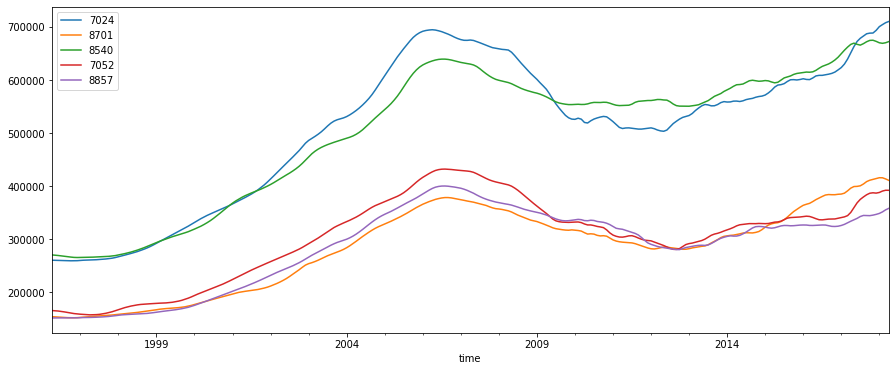

In [44]:
for i in range(5):
    df_ts[i].value.plot(label=df_ts[i].Zipcode[0],figsize=(15,6))
    plt.legend()

In [45]:
#Calculate monthly returns in new column 'monthly_ret' for each zipcode.
for zc in range(len(df_ts)):
    df_ts[zc]['monthly_ret']=np.nan*len(df_ts[zc])
    for i in range(len(df_ts[zc])-1):
        df_ts[zc]['monthly_ret'][i+1]= (df_ts[zc].value.iloc[i+1] / df_ts[zc].value.iloc[i]) - 1

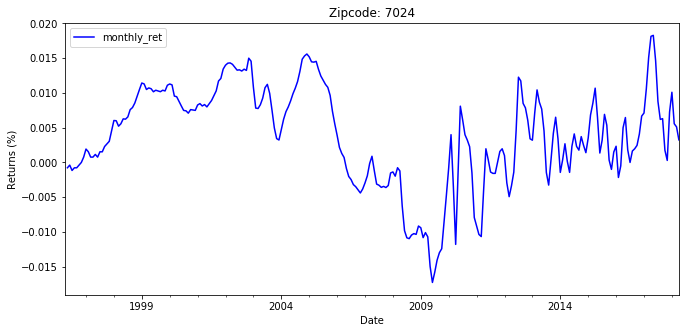

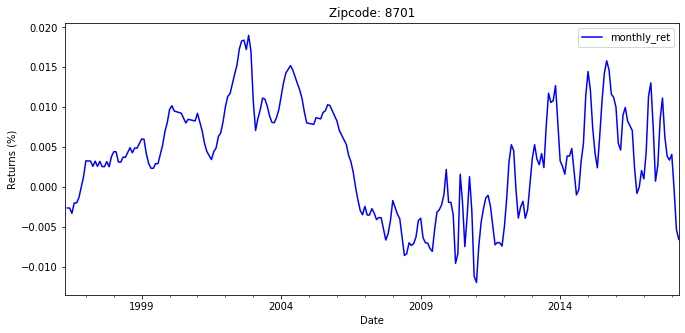

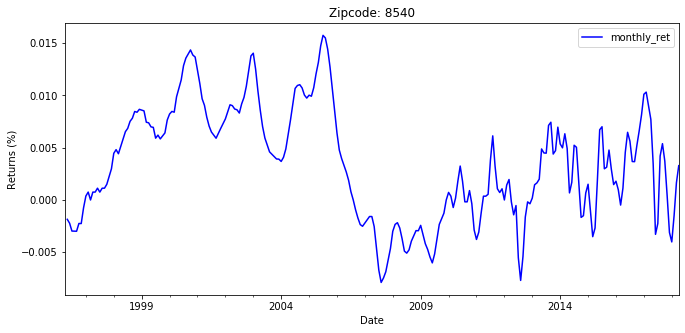

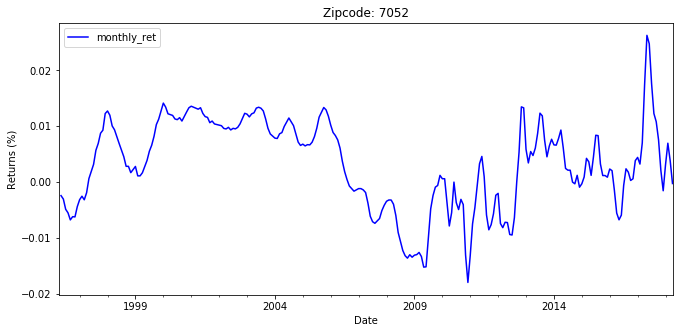

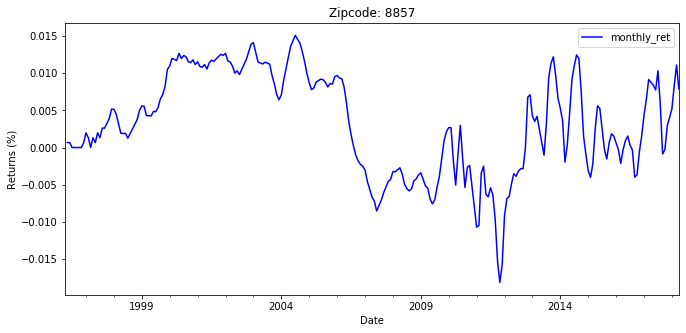

In [46]:
#Plot the monthly returns of each zipcode
for i in range(len(df_ts)):
    df_ts[i].monthly_ret.plot(figsize=(11,5), color = 'b')
    plt.title(f'Zipcode: {df_ts[i].Zipcode[0]}')
    plt.xlabel('Date')
    plt.ylabel('Returns (%)')
    plt.legend(loc='best')
    plt.show()

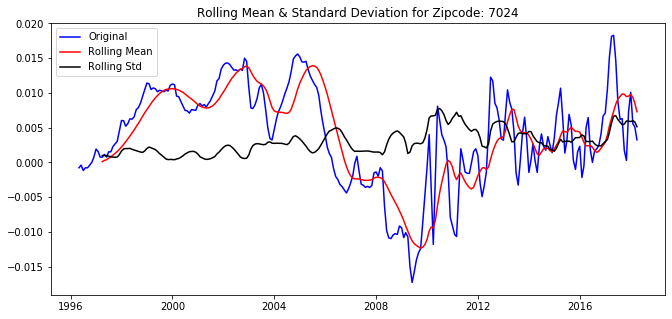

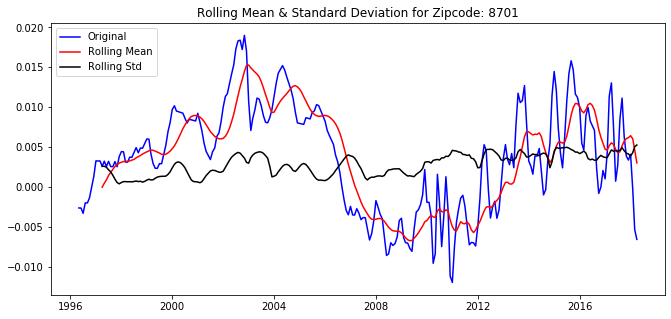

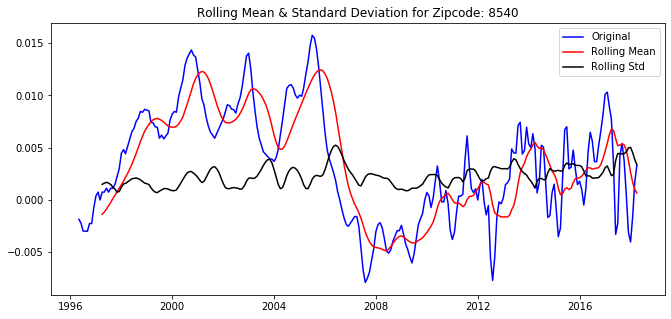

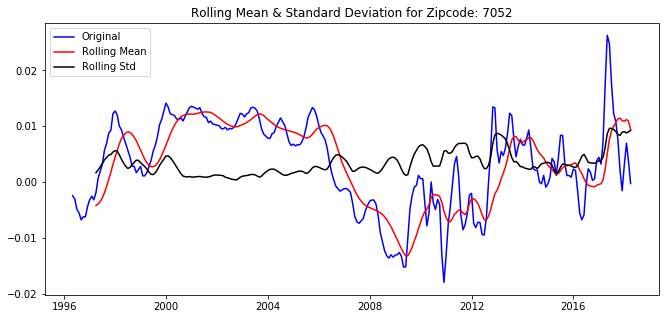

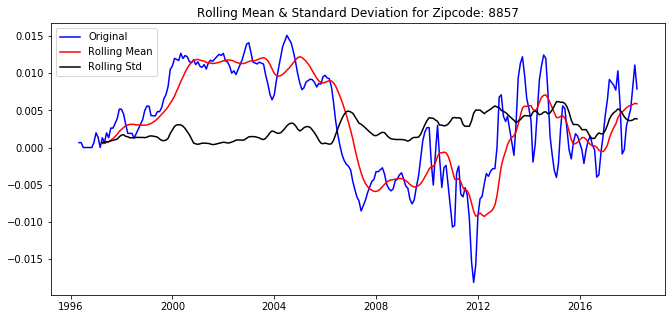

In [47]:
#Plot each of the zipcodes' returns with their respective rolling mean and rolling standard deviation.
#Vizually test for stationarity.
for i in range(len(df_ts)):
    rolmean = df_ts[i].monthly_ret.rolling(window = 12, center = False).mean()
    rolstd = df_ts[i].monthly_ret.rolling(window = 12, center = False).std()
    fig = plt.figure(figsize=(11,5))
    orig = plt.plot(df_ts[i].monthly_ret, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for Zipcode: {df_ts[i].Zipcode[0]}')
    plt.show()

In [48]:
for i in range(5):
    results = adfuller(df_ts[i].monthly_ret.dropna())
    print(f'ADFuller test p-value for zipcode: {df_ts[i].Zipcode[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 7024
p-value: 0.18709632743434468
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 8701
p-value: 0.4465379577146909
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 8540
p-value: 0.26923685906487793
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 7052
p-value: 0.5675275850567671
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 8857
p-value: 0.21538019664285113
Fail to reject the null hypothesis. Data is not stationary.



In [49]:
for i in range(5):
    #Perform adfuller test and drop NaN values created when calculating monthly returns.
    results = adfuller(df_ts[i].monthly_ret.diff().dropna())
    print(f'ADFuller test p-value for zipcode: {df_ts[i].Zipcode[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 7024
p-value: 0.0006237576537032874
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 8701
p-value: 3.80930014483174e-07
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 8540
p-value: 1.1488314784962288e-07
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 7052
p-value: 3.4939361214008656e-09
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 8857
p-value: 8.68696905022404e-05
Reject the null hypothesis. Data is stationary.



In [50]:
#Instantiate individual time series for each of the zipcodes.
ts_07024 = df_ts[0].monthly_ret.dropna() #Zipcode 07024 monthly returns time series
ts_07024d = df_ts[0].monthly_ret.diff().dropna() #Zipcode 07024 monthly returns differenced time series

ts_08701 = df_ts[1].monthly_ret.dropna()#Zipcode 08701 monthly returns time series
ts_08701d = df_ts[1].monthly_ret.diff().dropna() #Zipcode 08701 monthly returns differenced time series

ts_08540 = df_ts[2].monthly_ret.dropna()#Zipcode 08540 monthly returns time series
ts_08540d = df_ts[2].monthly_ret.diff().dropna()#Zipcode 08540 monthly returns differenced time series

ts_07052 = df_ts[3].monthly_ret.dropna()#Zipcode 07052 monthly returns time series
ts_07052d = df_ts[3].monthly_ret.diff().dropna()#Zipcode 07052 monthly returns differenced time series

ts_08857 = df_ts[4].monthly_ret.dropna()#Zipcode 08857 monthly returns time series
ts_08857d = df_ts[4].monthly_ret.diff().dropna()#Zipcode 08857 monthly returns differenced time series

Lets run the ACP, and PACF plots on each zipcode and see how they perform individually. We will try to identify the 1-year, 3-year, 5-year and 10-year ROI for the zipcodes and analyze the results. We will test the model with actual test data, and then also run it for future unknown data. 

## 1. Zipcode: 07024 Analysis

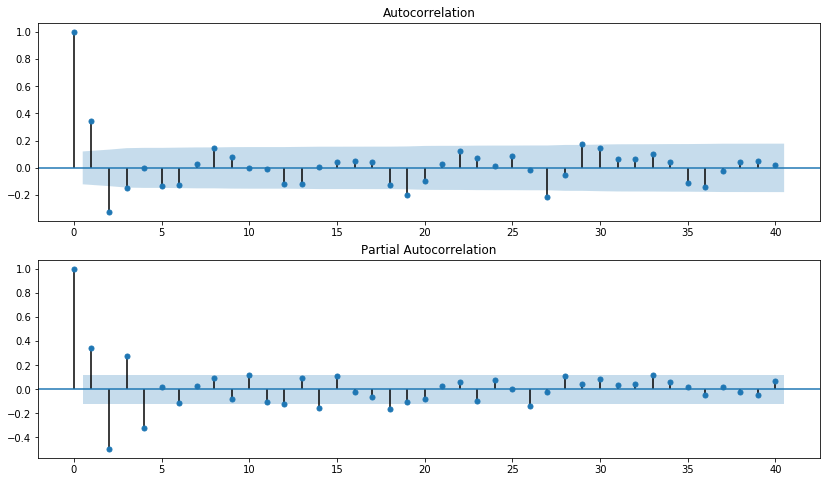

In [51]:
acf_pacf(ts_07024d)

In [52]:
def seasonal_plots(df,N=13,lags=[12,24,36,48,60,72]):
    #Differencing the rolling mean to find seasonality in the resulting acf plot.
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(13,8))
    rolling = ts_07024 - ts_07024.rolling(N).mean()
    plot_acf(rolling.dropna(),lags=lags,ax=ax1)
    plot_pacf(rolling.dropna(),lags=lags,ax=ax2)
    plt.show();

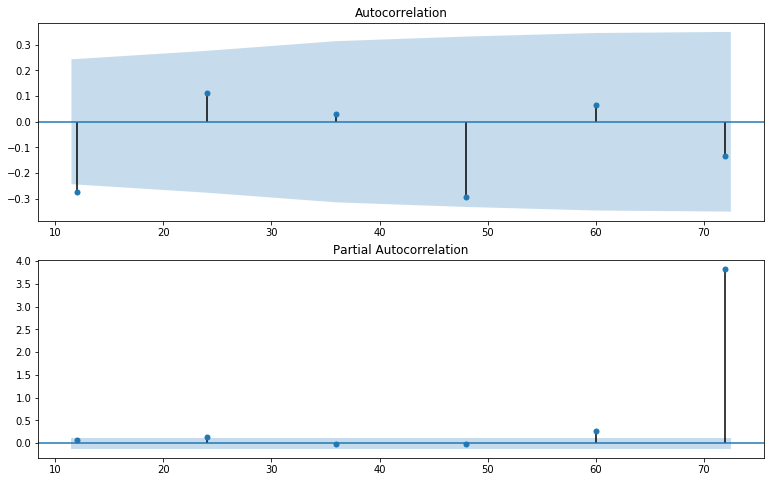

In [53]:
seasonal_plots(ts_07024d, N=13)

In [54]:
#Use auto arima function to find the best non-seasonal and seasonal parameters to fit the model.
results = pm.auto_arima(ts_07024,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-2570.738, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1859.588, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2325.126, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2229.395, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1793.868, Time=0.02 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-2564.600, Time=0.23 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-2568.680, Time=0.28 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=-2437.320, Time=1.11 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=-2565.149, Time=1.58 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-2568.895, Time=0.16 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-2564.824, Time=1.61 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=-2454.767, Time=0.68 sec
 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.77 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-2253.042, Time=0.45 sec
 ARIMA(1,0,

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

In [55]:
def train_test(df):
    #Set trainning dsata before 2016
    train = df[:'2015-04']
    #Set test data starting 2016
    test = df['2015-05':]
    return train, test

def model_fit(df,pdq,pdqs):
    train, test = train_test(df)
    model = SARIMAX(train,order=pdq,seasonal_order=pdqs)
    results = model.fit()
    results.summary
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show();
    return train, test, results

                                     SARIMAX Results                                      
Dep. Variable:                        monthly_ret   No. Observations:                  228
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 12)   Log Likelihood                1119.491
Date:                            Wed, 26 May 2021   AIC                          -2230.982
Time:                                    22:13:21   BIC                          -2217.265
Sample:                                05-01-1996   HQIC                         -2225.448
                                     - 04-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9309      0.031     30.431      0.000       0.871       0.991
ma.L1          0.5998      0.050   

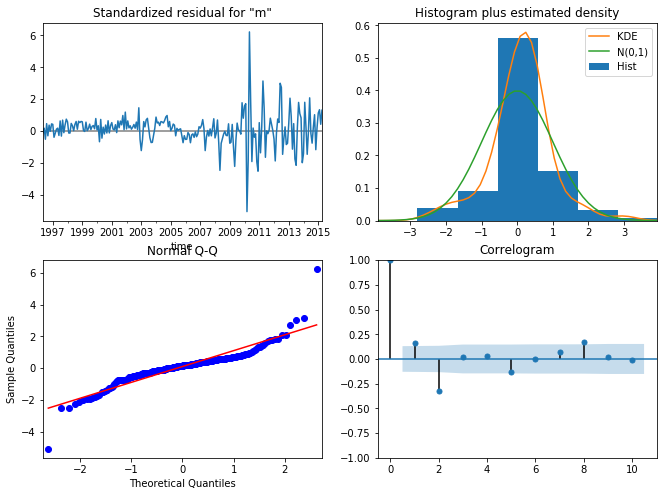

In [56]:
pdq = (1,0,1)
pdqs = (0,0,1,12)
train, test, results = model_fit(ts_07024,pdq=pdq,pdqs=pdqs)

In [57]:
def test_RMSE(df,pdq,pdqs, display=True):
    X = df.values
    train, test = X[:-36],X[-36:]
    history = [x for x in train]
    predictions = []
    for t in range(len(test)):
        model = SARIMAX(history, order=pdq,seasonal_order=pdqs)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = sqrt(MSE(test, predictions))
    print('SARIMA model RMSE on test data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        plt.title('Actual Test Data vs. Predictions')
        plt.plot(history[-36:],label='Actual', color='b')
        plt.plot(predictions,label='Predictions',color='r')
        plt.legend(loc='best')
        plt.show()

def train_RMSE(train, results, display = True):
    train_pred = results.predict(-36)
    rmse = sqrt(MSE(train[-36:],train_pred))
    print(f'SARIMA model RMSE on train data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        train[-60:].plot(label='Actual',color='b')
        train_pred.plot(label='Predicted',color='r')
        plt.legend(loc='best')
        plt.title('Actual Train Data vs. Predicted Returns')
        plt.show()

SARIMA model RMSE on train data: 0.00236


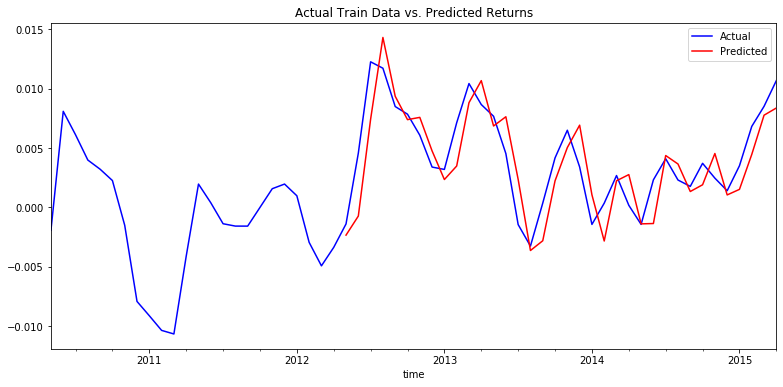

In [58]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.00268


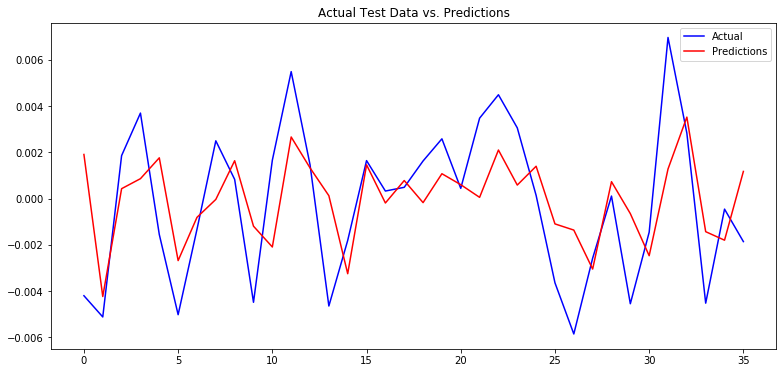

In [59]:
test_RMSE(ts_07024d,pdq=pdq,pdqs=pdqs, display=True)

In [60]:
def forecast_model(df,pdq,pdqs, display=True,zc='input zipcode'):
    model = SARIMAX(df, order=pdq,seasonal_order=pdqs)
    model_fit = model.fit()
    output = model_fit.get_prediction(start='2018-04',end='2028-04', dynamic=True)
    forecast_ci = output.conf_int()
    if display:
        fig, ax = plt.subplots(figsize=(13,6))
        output.predicted_mean.plot(label='Forecast')
        ax.fill_between(forecast_ci.index,forecast_ci.iloc[:, 0],forecast_ci.iloc[:, 1],
                        color='k', alpha=.25,label='Conf Interval')
        plt.title('Forecast of Monthly Returns')
        plt.xlabel('Time')
        plt.legend(loc='best')
        plt.show()
    year_1= (1+output.predicted_mean[:12]).prod()-1
    year_3=(1+output.predicted_mean[:36]).prod()-1
    year_5= (1+output.predicted_mean[:60]).prod()-1
    year_10=(1+output.predicted_mean).prod()-1
    print(f'Total expected return in 1 year: {round(year_1*100,2)}%')
    print(f'Total expected return in 3 years: {round(year_3*100,2)}%')
    print(f'Total expected return in 5 year: {round(year_5*100,2)}%')
    print(f'Total expected return in 10 years: {round(year_10*100,2)}%')
    tot_ret = [zc,year_1,year_3,year_5,year_10]
    return tot_ret

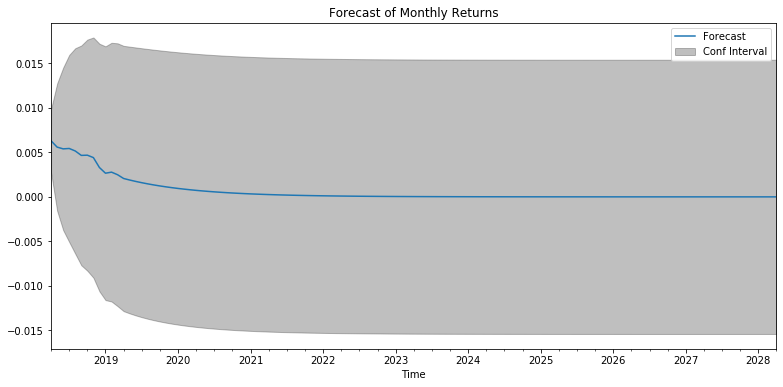

Total expected return in 1 year: 5.42%
Total expected return in 3 years: 7.74%
Total expected return in 5 year: 8.03%
Total expected return in 10 years: 8.07%


In [61]:
ret_07024 = forecast_model(ts_07024,pdq=pdq,pdqs=pdqs,zc=70808)

## 2. Zipcode: 08701 Analysis

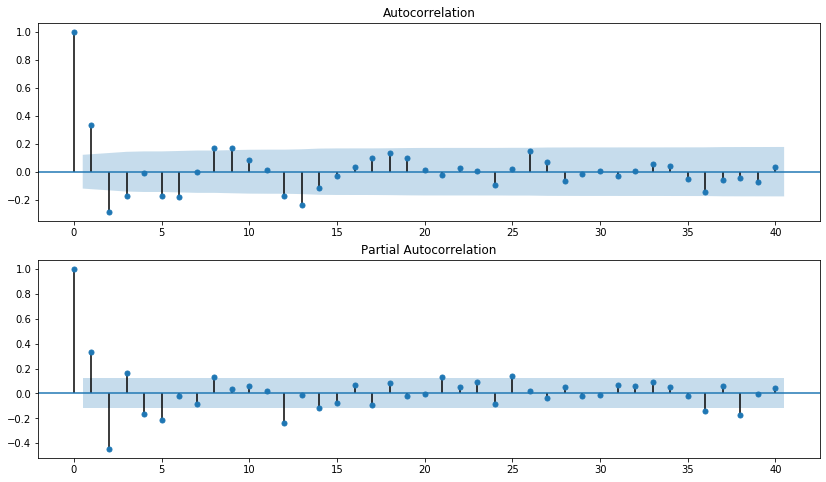

In [62]:
acf_pacf(ts_08701d)

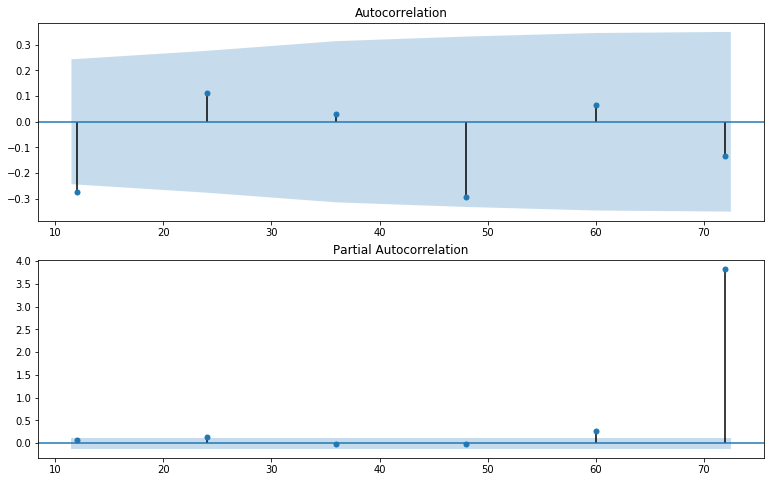

In [63]:
seasonal_plots(ts_08701, N=13)

In [64]:
results = pm.auto_arima(ts_08701,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-2463.151, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1903.429, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2470.190, Time=0.30 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2246.831, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1830.211, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-2464.961, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=-2357.533, Time=0.60 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=-2488.494, Time=0.55 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-2474.700, Time=0.30 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=-2358.520, Time=1.15 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=-2384.815, Time=0.58 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=-2380.017, Time=1.29 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-1991.555, Time=0.39 sec
 ARIMA(2,0,

ARIMA(order=(1, 0, 3), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

                                      SARIMAX Results                                       
Dep. Variable:                          monthly_ret   No. Observations:                  228
Model:             SARIMAX(1, 0, 3)x(1, 0, [1], 12)   Log Likelihood                1083.779
Date:                              Wed, 26 May 2021   AIC                          -2153.559
Time:                                      22:14:32   BIC                          -2129.554
Sample:                                  05-01-1996   HQIC                         -2143.874
                                       - 04-01-2015                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9670      0.031     31.481      0.000       0.907       1.027
ma.L1          0.49

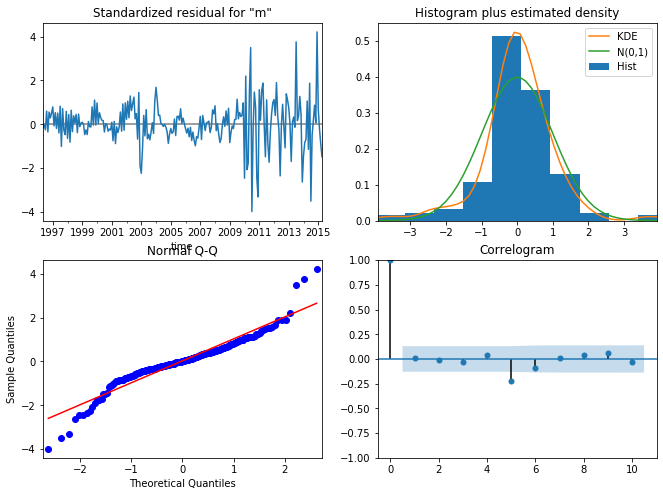

In [65]:
pdq = (1,0,3)
pdqs = (1,0,1,12)
train, test, results = model_fit(ts_08701,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.00306


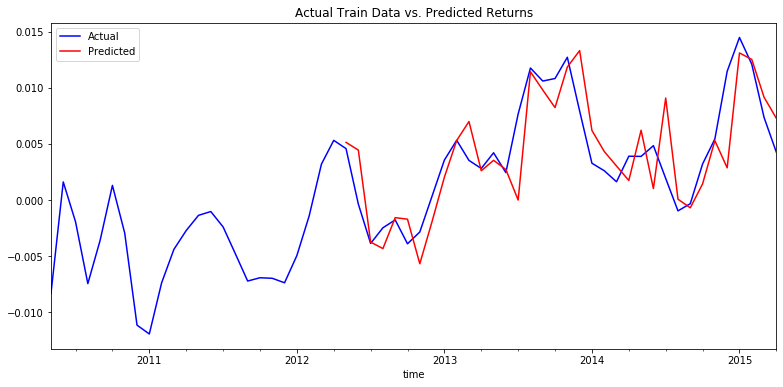

In [66]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.00311


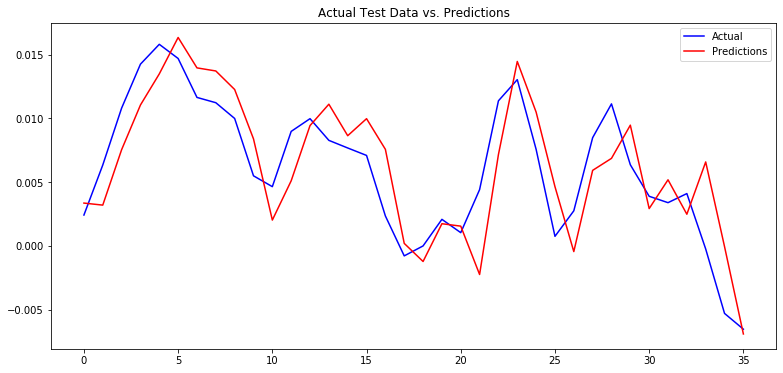

In [67]:
test_RMSE(ts_08701,pdq=pdq,pdqs=pdqs, display=True)

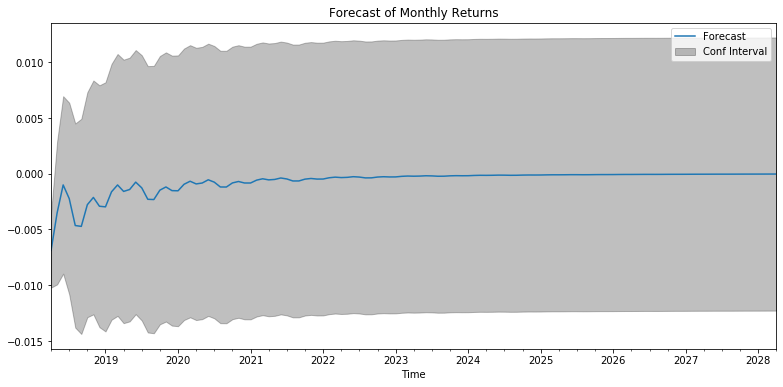

Total expected return in 1 year: -3.58%
Total expected return in 3 years: -6.12%
Total expected return in 5 year: -6.99%
Total expected return in 10 years: -7.54%


In [68]:
ret_08701 = forecast_model(ts_08701,pdq=pdq,pdqs=pdqs,zc=8701)

## 3. Zipcode: 08540 Analysis

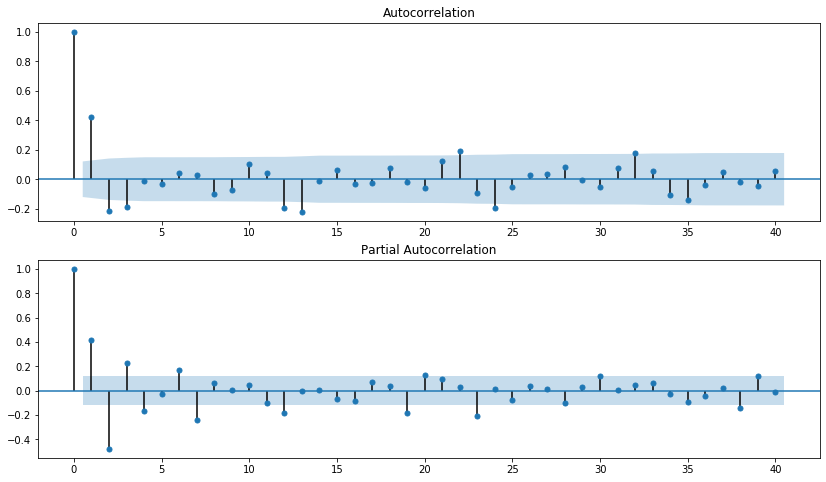

In [69]:
acf_pacf(ts_08540d)

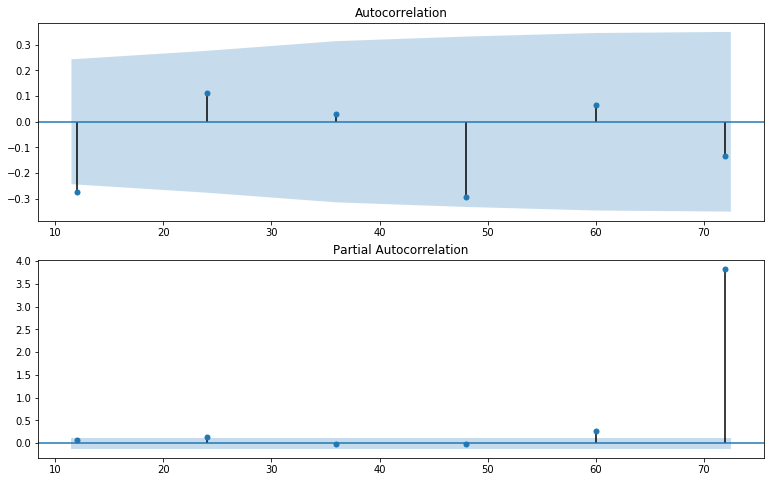

In [70]:
seasonal_plots(ts_08540, N=13)

In [71]:
results = pm.auto_arima(ts_08540,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-2781.535, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-2007.361, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2545.693, Time=0.30 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1916.860, Time=0.02 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-2671.420, Time=0.15 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=-2673.757, Time=1.82 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.77 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-2779.676, Time=0.08 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-2505.586, Time=0.54 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=-2715.618, Time=0.87 sec
 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=-2775.883, Time=1.79 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-2381.354, Time=0.46 sec
 ARIMA(1,0,0)(1,0,1)[12

ARIMA(order=(1, 0, 3), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

                                     SARIMAX Results                                      
Dep. Variable:                        monthly_ret   No. Observations:                  228
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                1057.993
Date:                            Wed, 26 May 2021   AIC                          -2105.987
Time:                                    22:15:16   BIC                          -2088.840
Sample:                                05-01-1996   HQIC                         -2099.069
                                     - 04-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9642      0.026     36.680      0.000       0.913       1.016
ma.L1          0.5740      0.043   

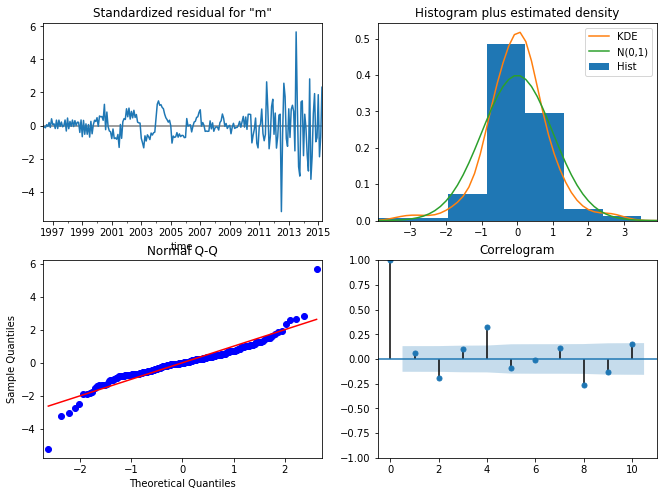

In [72]:
pdq = (1,0,1)
pdqs = (1,0,1,12)
train, test, results = model_fit(ts_08540,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.00456


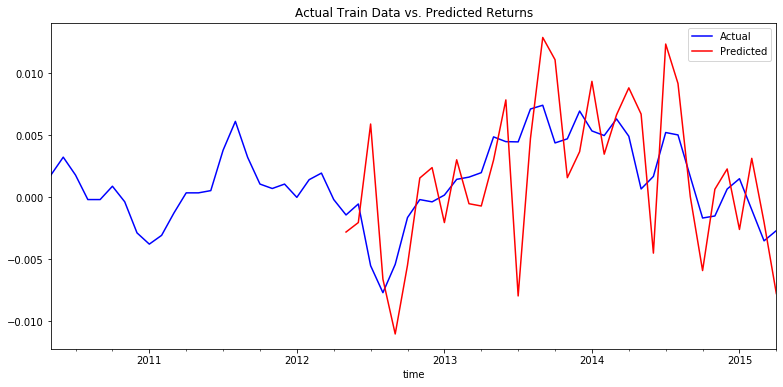

In [73]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.00296


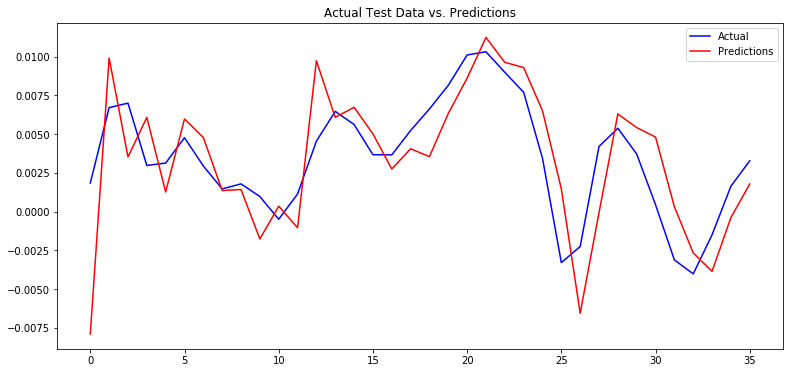

In [74]:
test_RMSE(ts_08540,pdq=pdq,pdqs=pdqs, display=True)

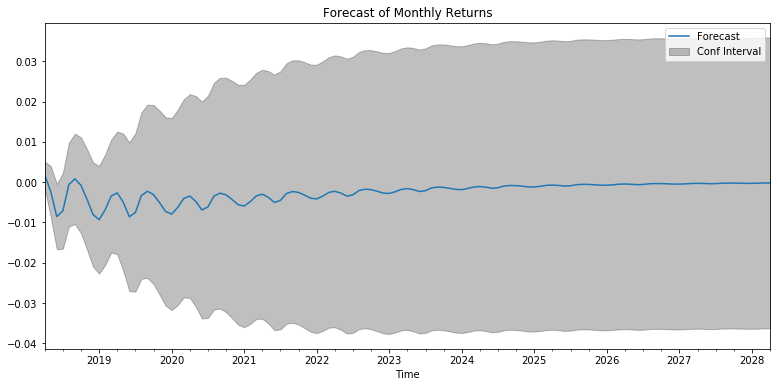

Total expected return in 1 year: -4.78%
Total expected return in 3 years: -15.39%
Total expected return in 5 year: -21.17%
Total expected return in 10 years: -25.05%


In [75]:
ret_08540 = forecast_model(ts_08540,pdq=pdq,pdqs=pdqs,zc=8540)

## 4. Zipcode: 07052 Analysis

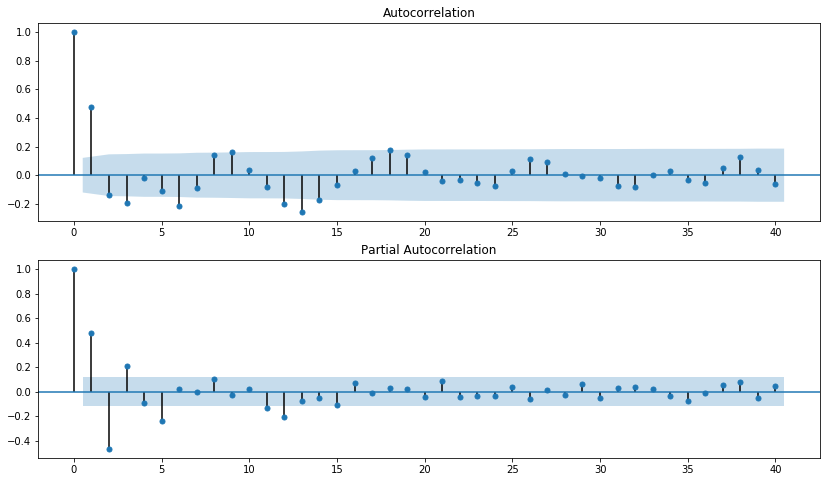

In [76]:
acf_pacf(ts_07052d)

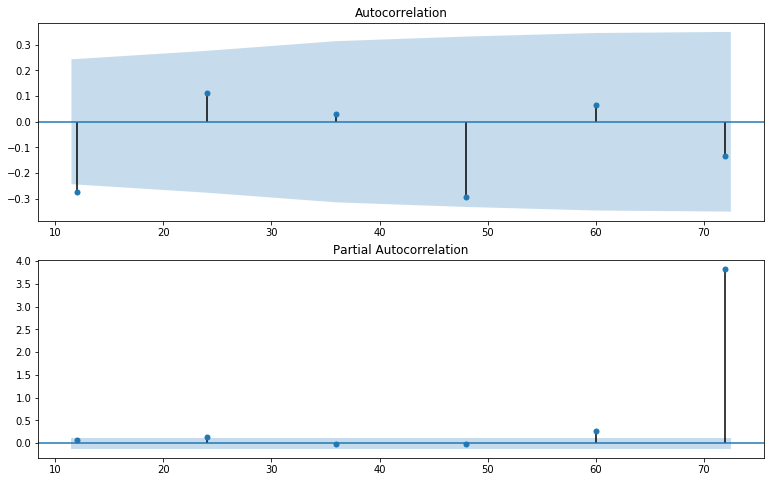

In [77]:
seasonal_plots(ts_07052, N=13)

In [78]:
results = pm.auto_arima(ts_07052,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-2546.032, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1803.890, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2330.094, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2149.057, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1763.094, Time=0.01 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-2552.520, Time=0.42 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-2552.687, Time=0.19 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-2552.074, Time=0.40 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-2120.084, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-2433.182, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-2557.146, Time=0.20 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=-2539.862, Time=0.47 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=-2543.324, Time=0.45 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=-2504.055, Time=0.46 sec
 ARIM

ARIMA(order=(2, 0, 3), scoring_args={}, seasonal_order=(2, 0, 0, 12),
      suppress_warnings=True)

                                      SARIMAX Results                                      
Dep. Variable:                         monthly_ret   No. Observations:                  228
Model:             SARIMAX(2, 0, 3)x(2, 0, [], 12)   Log Likelihood                1101.375
Date:                             Wed, 26 May 2021   AIC                          -2186.750
Time:                                     22:16:02   BIC                          -2159.315
Sample:                                 05-01-1996   HQIC                         -2175.681
                                      - 04-01-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1338      0.372      3.051      0.002       0.406       1.862
ar.L2         -0.1749      

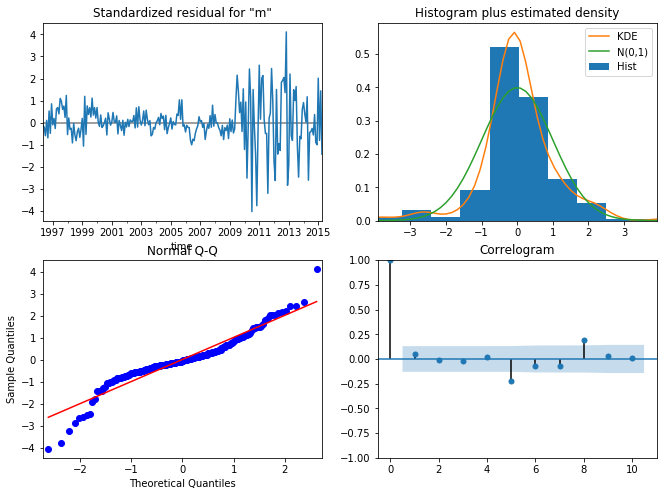

In [79]:
pdq = (2,0,3)
pdqs = (2,0,0,12)
train, test, results = model_fit(ts_07052,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.00289


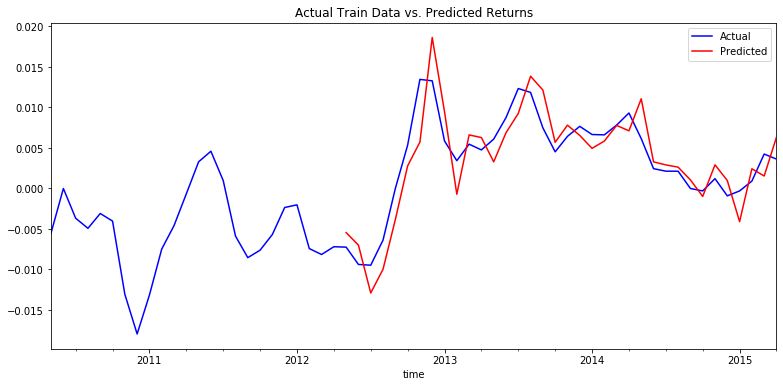

In [80]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.00300


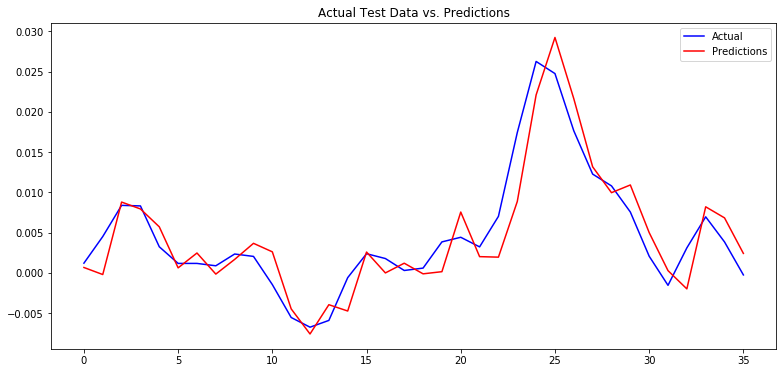

In [81]:
test_RMSE(ts_07052,pdq=pdq,pdqs=pdqs, display=True)

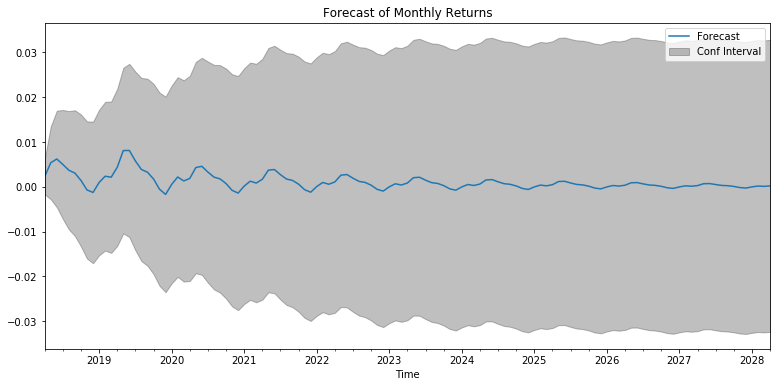

Total expected return in 1 year: 3.1%
Total expected return in 3 years: 9.0%
Total expected return in 5 year: 11.87%
Total expected return in 10 years: 14.7%


In [82]:
ret_07052 = forecast_model(ts_07052,pdq=pdq,pdqs=pdqs,zc=7052)

## 5. Zipcode 08857

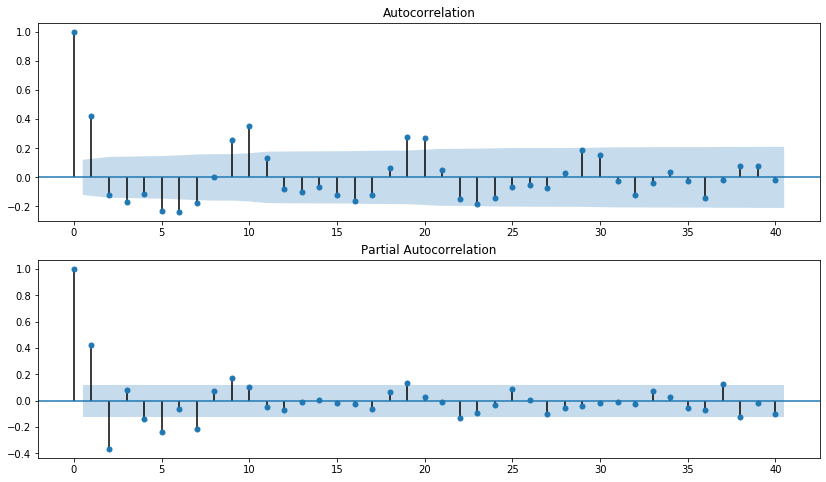

In [83]:
acf_pacf(ts_08857d)

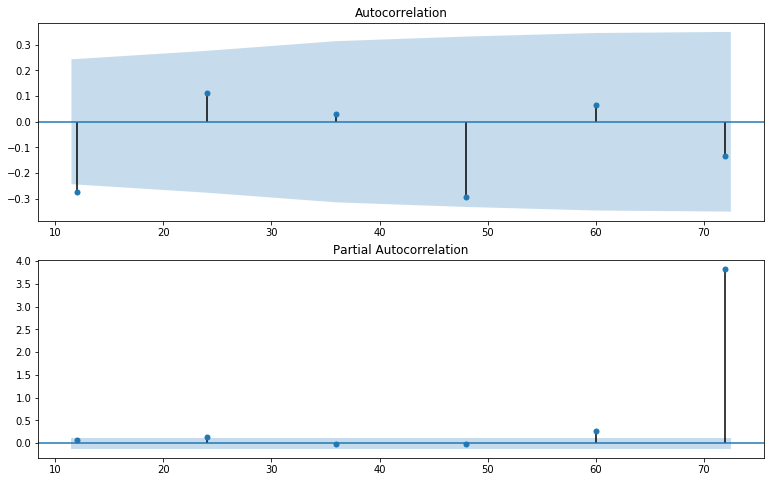

In [89]:
seasonal_plots(ts_08857, N=13)

In [90]:
results = pm.auto_arima(ts_08857,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-2641.240, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1883.081, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2549.144, Time=0.38 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2282.961, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1829.320, Time=0.01 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-2632.324, Time=0.15 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-2633.905, Time=0.32 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=-2553.326, Time=1.19 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=-2639.794, Time=2.31 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-2634.324, Time=0.06 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-2386.774, Time=0.63 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=-2553.401, Time=0.94 sec
 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=-2642.019, Time=3.10 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=-2282.344, Time=1.82 sec
 ARIM

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(2, 0, 2, 12),
      suppress_warnings=True)

                                        SARIMAX Results                                        
Dep. Variable:                             monthly_ret   No. Observations:                  228
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 12)   Log Likelihood                1158.744
Date:                                 Wed, 26 May 2021   AIC                          -2303.489
Time:                                         22:33:19   BIC                          -2279.483
Sample:                                     05-01-1996   HQIC                         -2293.803
                                          - 04-01-2015                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9447      0.021     45.551      0.000       0.904       0

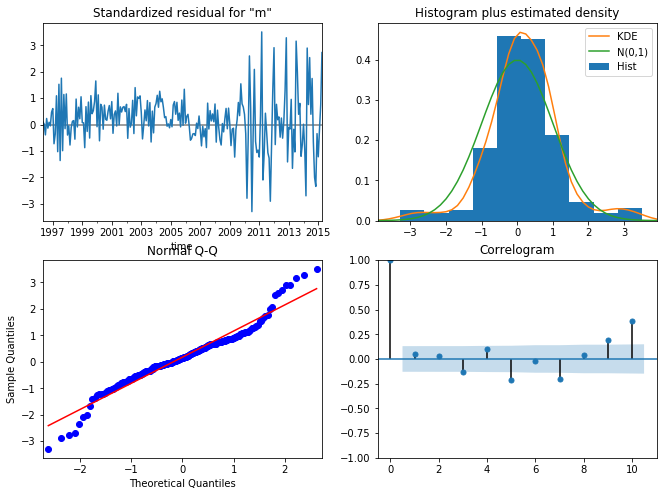

In [91]:
pdq = (1,0,1)
pdqs = (2,0,2,12)
train, test, results = model_fit(ts_08857,pdq=pdq,pdqs=pdqs)

SARIMA model RMSE on train data: 0.00224


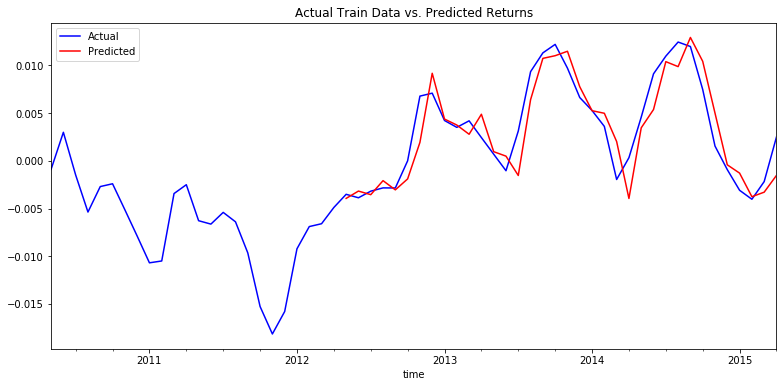

In [92]:
train_RMSE(train, results)

SARIMA model RMSE on test data: 0.00207


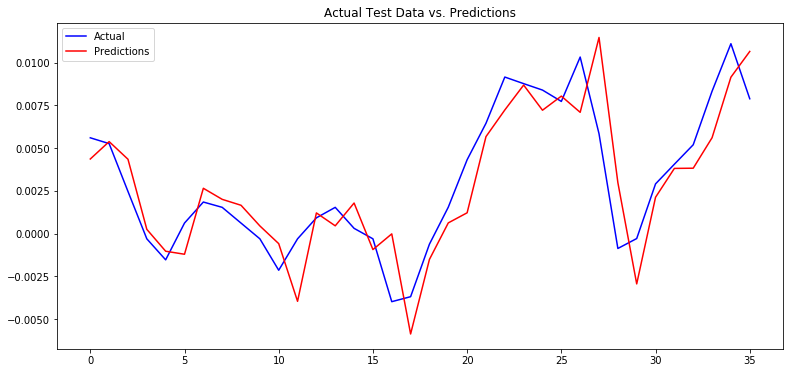

In [93]:
test_RMSE(ts_08857,pdq=pdq,pdqs=pdqs, display=True)

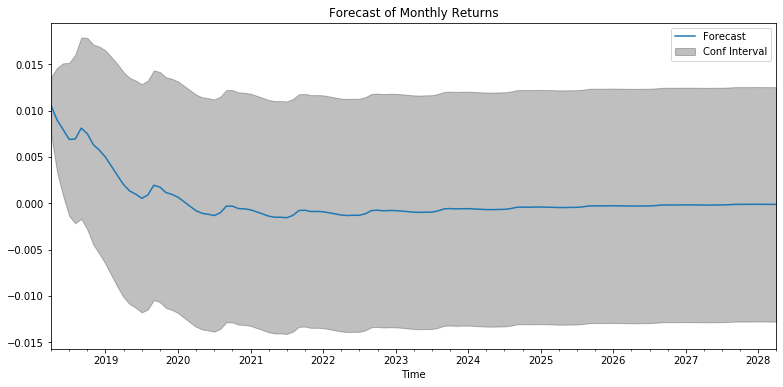

Total expected return in 1 year: 8.39%
Total expected return in 3 years: 8.59%
Total expected return in 5 year: 5.82%
Total expected return in 10 years: 3.28%


In [94]:
ret_08857 = forecast_model(ts_08857,pdq=pdq,pdqs=pdqs,zc=8857)

# Conclusion

After analyzing the data from NY and NJ, and selecting NJ for our zipcode specific analysis, we can see that the final analysis does not conclusively provide a very compelling investment opportunity in any of the 5 zipcodes selected. One reason for this could be because of the effects of the 2008 financial crisis affecting out forecasts. But this would only affect the longer term forecast and not the 1 and 3 year forecasts. 

However, it is important to note that from the analysis of the two states, we did see the 2-year, and the 10-year returns significantly dropping across the early 2000's. The mean ROI for the state of NJ was very much in line with the mean return of the best performing zipcode we modeled. Hence their seems to be a take-away from this analysis on whether NJ even provides a compelling investment opportunity. 

Their is a need to further analyze the data, by running more complex models. For example, the models can be further improved by including exogenous variables such as tax rates, and other outside conditions. 